<a href="https://colab.research.google.com/github/AjaySreekumar47/vlm-research/blob/main/EndoVisio2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from collections import defaultdict, Counter
from google.colab import drive
import json
import zipfile
import shutil

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Set up paths - adjust these according to your folder structure
DRIVE_PATH = '/content/drive/MyDrive/'  # Adjust if your data is in a subfolder
DATA_PATH = os.path.join(DRIVE_PATH, 'Endo2017')  # Adjust folder name as needed
# EXTRACTED_PATH = os.path.join(DATA_PATH, 'extracted')  # Where to extract files
EXTRACTED_PATH = os.path.join('/content/extracted')  # Where to extract files

print(f"Looking for data in: {DATA_PATH}")
print(f"Will extract to: {EXTRACTED_PATH}")

class EndoVisDatasetProcessor:
    def __init__(self, data_path, extracted_path):
        self.data_path = Path(data_path)
        self.extracted_path = Path(extracted_path)
        self.zip_files = []
        self.sequences = {}

    def find_zip_files(self):
        """Find all zip files in the dataset folder"""
        print("=" * 60)
        print("FINDING ZIP FILES")
        print("=" * 60)

        zip_files = list(self.data_path.glob("*.zip"))

        if not zip_files:
            print("❌ No zip files found!")
            return False

        print(f"✅ Found {len(zip_files)} zip files:")
        for zip_file in zip_files:
            print(f"   📦 {zip_file.name} ({zip_file.stat().st_size / (1024*1024):.1f} MB)")

        self.zip_files = sorted(zip_files)
        return True

    def extract_zip_files(self, force_extract=False):
        """Extract all zip files"""
        print("\n" + "=" * 60)
        print("EXTRACTING ZIP FILES")
        print("=" * 60)

        # Create extraction directory
        self.extracted_path.mkdir(exist_ok=True)

        for zip_file in self.zip_files:
            extract_folder = self.extracted_path / zip_file.stem

            if extract_folder.exists() and not force_extract:
                print(f"⏭️  {zip_file.name} already extracted, skipping...")
                continue

            print(f"📦 Extracting {zip_file.name}...")

            try:
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    zip_ref.extractall(extract_folder)
                print(f"   ✅ Extracted to {extract_folder}")

                # List contents briefly
                contents = list(extract_folder.rglob('*'))
                dirs = [c for c in contents if c.is_dir()]
                files = [c for c in contents if c.is_file()]
                print(f"   📁 {len(dirs)} directories, 📄 {len(files)} files")

            except Exception as e:
                print(f"   ❌ Error extracting {zip_file.name}: {e}")

    def explore_extracted_structure(self):
        """Explore the structure of extracted files"""
        print("\n" + "=" * 60)
        print("EXTRACTED DATA STRUCTURE")
        print("=" * 60)

        if not self.extracted_path.exists():
            print("❌ No extracted data found. Run extraction first.")
            return

        def print_tree(path, prefix="", max_depth=4, current_depth=0):
            if current_depth > max_depth:
                return

            try:
                items = sorted(path.iterdir()) if path.is_dir() else []
                # Limit items shown to avoid too much output
                if len(items) > 10:
                    items = items[:10]
                    show_truncated = True
                else:
                    show_truncated = False

                for i, item in enumerate(items):
                    is_last = i == len(items) - 1 and not show_truncated
                    current_prefix = "└── " if is_last else "├── "

                    # Add file count for directories
                    if item.is_dir():
                        try:
                            file_count = len([f for f in item.iterdir() if f.is_file()])
                            print(f"{prefix}{current_prefix}{item.name}/ ({file_count} files)")
                        except:
                            print(f"{prefix}{current_prefix}{item.name}/")
                    else:
                        print(f"{prefix}{current_prefix}{item.name}")

                    if item.is_dir() and current_depth < max_depth:
                        next_prefix = prefix + ("    " if is_last and not show_truncated else "│   ")
                        print_tree(item, next_prefix, max_depth, current_depth + 1)

                if show_truncated:
                    print(f"{prefix}└── ... ({len(list(path.iterdir())) - 10} more items)")
            except PermissionError:
                print(f"{prefix}❌ Permission denied")

        for extracted_folder in sorted(self.extracted_path.iterdir()):
            if extracted_folder.is_dir():
                print(f"\n📦 {extracted_folder.name}:")
                print_tree(extracted_folder)

    def analyze_sequences(self):
        """Analyze individual sequences"""
        print("\n" + "=" * 60)
        print("SEQUENCE ANALYSIS")
        print("=" * 60)

        sequence_data = {}

        # Look for instrument dataset folders
        for extracted_folder in self.extracted_path.iterdir():
            if not extracted_folder.is_dir():
                continue

            # Find all instrument_dataset_* folders
            dataset_folders = list(extracted_folder.glob("instrument_dataset_*"))

            for dataset_folder in dataset_folders:
                sequence_name = dataset_folder.name
                print(f"\n🔍 Analyzing {sequence_name}:")

                # Look for common folders
                folders_to_check = {
                    'images': ['left_frames', 'frames', 'images'],
                    'binary_masks': ['ground_truth', 'binary', 'masks'],
                    'parts_masks': ['parts', 'part_masks'],
                    'type_masks': ['type', 'type_masks', 'instruments']
                }

                sequence_info = {'name': sequence_name, 'path': dataset_folder}

                for category, possible_names in folders_to_check.items():
                    found_folder = None
                    for name in possible_names:
                        candidate = dataset_folder / name
                        if candidate.exists() and candidate.is_dir():
                            found_folder = candidate
                            break

                    if found_folder:
                        files = list(found_folder.glob("*"))
                        image_files = [f for f in files if f.suffix.lower() in ['.png', '.jpg', '.jpeg']]
                        sequence_info[category] = {
                            'path': found_folder,
                            'count': len(image_files),
                            'files': image_files[:5]  # Sample files
                        }
                        print(f"   📁 {category}: {len(image_files)} files in {found_folder.name}/")
                    else:
                        sequence_info[category] = None
                        print(f"   ❌ {category}: Not found")

                sequence_data[sequence_name] = sequence_info

        self.sequences = sequence_data
        return sequence_data

    def display_sample_data(self):
        """Display sample images and masks"""
        print("\n" + "=" * 60)
        print("SAMPLE DATA VISUALIZATION")
        print("=" * 60)

        # Find a sequence with both images and masks
        sample_sequence = None
        for seq_name, seq_info in self.sequences.items():
            if (seq_info.get('images') and seq_info.get('binary_masks') and
                seq_info['images']['count'] > 0 and seq_info['binary_masks']['count'] > 0):
                sample_sequence = seq_info
                break

        if not sample_sequence:
            print("❌ No sequence found with both images and masks")
            return

        print(f"📷 Showing samples from: {sample_sequence['name']}")

        # Get sample files
        image_files = sample_sequence['images']['files'][:3]
        mask_files = sample_sequence['binary_masks']['files'][:3]

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Display images
        for i, img_path in enumerate(image_files):
            if i >= 3:
                break
            img = cv2.imread(str(img_path))
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[0, i].imshow(img_rgb)
                axes[0, i].set_title(f"Image: {img_path.name}")
                axes[0, i].axis('off')

        # Display masks
        for i, mask_path in enumerate(mask_files):
            if i >= 3:
                break
            mask = cv2.imread(str(mask_path), 0)
            if mask is not None:
                axes[1, i].imshow(mask, cmap='gray')
                axes[1, i].set_title(f"Mask: {mask_path.name}")
                axes[1, i].axis('off')

                # Show unique values
                unique_vals = np.unique(mask)
                print(f"   {mask_path.name}: unique values = {unique_vals}")

        plt.tight_layout()
        plt.show()

    def analyze_mask_distributions(self):
        """Analyze the distribution of mask values"""
        print("\n" + "=" * 60)
        print("MASK ANALYSIS")
        print("=" * 60)

        mask_stats = {}

        for seq_name, seq_info in self.sequences.items():
            if not seq_info.get('binary_masks'):
                continue

            print(f"\n🎯 Analyzing masks in {seq_name}:")

            mask_files = seq_info['binary_masks']['files']
            if not mask_files:
                continue

            # Sample a few masks to understand the format
            sample_masks = mask_files[:min(5, len(mask_files))]
            all_unique_values = set()

            for mask_file in sample_masks:
                mask = cv2.imread(str(mask_file), 0)
                if mask is not None:
                    unique_vals = np.unique(mask)
                    all_unique_values.update(unique_vals)

            all_unique_values = sorted(list(all_unique_values))
            print(f"   Unique pixel values across samples: {all_unique_values}")

            # Determine mask type
            if len(all_unique_values) == 2 and 0 in all_unique_values:
                mask_type = "Binary (background + instrument)"
            elif len(all_unique_values) <= 10:
                mask_type = f"Multi-class ({len(all_unique_values)} classes)"
            else:
                mask_type = "Continuous or RGB"

            print(f"   Mask type: {mask_type}")
            mask_stats[seq_name] = {
                'type': mask_type,
                'unique_values': all_unique_values,
                'file_count': len(mask_files)
            }

        return mask_stats

    def load_instrument_mapping(self):
        """Load the instrument type mapping JSON"""
        print("\n" + "=" * 60)
        print("INSTRUMENT TYPE MAPPING")
        print("=" * 60)

        mapping_file = self.data_path / "instrument_type_mapping.json"

        if mapping_file.exists():
            try:
                with open(mapping_file, 'r') as f:
                    mapping = json.load(f)
                print("✅ Instrument type mapping loaded:")
                print(json.dumps(mapping, indent=2))
                return mapping
            except Exception as e:
                print(f"❌ Error loading mapping: {e}")
        else:
            print("❌ instrument_type_mapping.json not found")

        return None

    def generate_dataset_summary(self):
        """Generate comprehensive dataset summary"""
        print("\n" + "=" * 60)
        print("DATASET SUMMARY")
        print("=" * 60)

        total_sequences = len(self.sequences)
        total_images = sum(seq.get('images', {}).get('count', 0) for seq in self.sequences.values())
        total_masks = sum(seq.get('binary_masks', {}).get('count', 0) for seq in self.sequences.values())

        print(f"📊 Total sequences found: {total_sequences}")
        print(f"📊 Total images: {total_images}")
        print(f"📊 Total masks: {total_masks}")

        # Sequence breakdown
        print(f"\n📋 Sequence breakdown:")
        for seq_name, seq_info in sorted(self.sequences.items()):
            img_count = seq_info.get('images', {}).get('count', 0)
            mask_count = seq_info.get('binary_masks', {}).get('count', 0)
            print(f"   {seq_name}: {img_count} images, {mask_count} masks")

        # Expected vs Actual
        print(f"\n🎯 Expected vs Actual:")
        print(f"   Expected: 8 training sequences (225 frames each) + test sequences")
        print(f"   Found: {total_sequences} sequences with {total_images} total images")

        if total_images > 0:
            print(f"\n✅ Dataset appears to be properly extracted!")
        else:
            print(f"\n⚠️  No images found. Check extraction or file paths.")

    def create_pytorch_dataloader_template(self):
        """Create a PyTorch DataLoader template"""
        print("\n" + "=" * 60)
        print("PYTORCH DATALOADER TEMPLATE")
        print("=" * 60)

        template = '''
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from pathlib import Path

class EndoVisDataset(Dataset):
    def __init__(self, sequences_info, task='binary', transform=None, target_transform=None):
        """
        Args:
            sequences_info: Dictionary with sequence information
            task: 'binary', 'parts', or 'type'
            transform: Optional transform to be applied on images
            target_transform: Optional transform to be applied on masks
        """
        self.task = task
        self.transform = transform
        self.target_transform = target_transform

        # Collect all image-mask pairs
        self.samples = []
        for seq_name, seq_info in sequences_info.items():
            if not seq_info.get('images') or not seq_info.get(f'{task}_masks'):
                continue

            images = sorted(seq_info['images']['files'])
            masks = sorted(seq_info[f'{task}_masks']['files'])

            # Match images with masks (assuming same naming convention)
            for img_path in images:
                # Find corresponding mask
                img_name = img_path.stem
                mask_path = None
                for m_path in masks:
                    if img_name in m_path.stem:
                        mask_path = m_path
                        break

                if mask_path:
                    self.samples.append((img_path, mask_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load mask
        mask = Image.open(mask_path).convert('L')  # Grayscale
        mask = np.array(mask)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            mask = torch.from_numpy(mask).long()

        return image, mask

# Example usage:
def create_dataloaders(sequences_info, batch_size=4):
    # Define transforms
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = EndoVisDataset(sequences_info, task='binary', transform=train_transform)
    val_dataset = EndoVisDataset(sequences_info, task='binary', transform=val_transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

# To use with your data:
# train_loader, val_loader = create_dataloaders(processor.sequences)
        '''

        print(template)

# Main execution
def main():
    processor = EndoVisDatasetProcessor(DATA_PATH, EXTRACTED_PATH)

    # Step 1: Find zip files
    if not processor.find_zip_files():
        return

    # Step 2: Extract zip files
    processor.extract_zip_files()

    # Step 3: Explore extracted structure
#     processor.explore_extracted_structure()

#     # Step 4: Analyze sequences
#     processor.analyze_sequences()

#     # Step 5: Display sample data
#     processor.display_sample_data()

#     # Step 6: Analyze masks
#     processor.analyze_mask_distributions()

#     # Step 7: Load instrument mapping
#     processor.load_instrument_mapping()

#     # Step 8: Generate summary
#     processor.generate_dataset_summary()

#     # Step 9: Create PyTorch template
#     processor.create_pytorch_dataloader_template()

#     print("\n✅ Complete analysis finished!")
#     print("You can now access the processor object to get sequence information:")
#     print("processor.sequences - Contains all sequence data")

#     return processor

# # Run the analysis
# processor = main()

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking for data in: /content/drive/MyDrive/Endo2017
Will extract to: /content/extracted
FINDING ZIP FILES
✅ Found 5 zip files:
   📦 instrument_1_4_training.zip (3012.4 MB)
   📦 instrument_5_8_training.zip (2986.9 MB)
   📦 instrument_1_4_testing.zip (1009.7 MB)
   📦 instrument_5_8_testing.zip (971.9 MB)
   📦 instrument_9_10_testing.zip (2024.6 MB)

EXTRACTING ZIP FILES
📦 Extracting instrument_1_4_testing.zip...
   ✅ Extracted to /content/extracted/instrument_1_4_testing
   📁 12 directories, 📄 605 files
📦 Extracting instrument_1_4_training.zip...
   ✅ Extracted to /content/extracted/instrument_1_4_training
   📁 28 directories, 📄 4505 files
📦 Extracting instrument_5_8_testing.zip...
   ✅ Extracted to /content/extracted/instrument_5_8_testing
   📁 12 directories, 📄 605 files
📦 Extracting instrument_5_8_training.zip...
   ✅ Extracted to /

AttributeError: 'NoneType' object has no attribute 'get'

SIMPLE DATA STRUCTURE CHECK
🔍 Checking training data structure...

📁 instrument_1_4_training:
  📂 instrument_dataset_1:
    📷 Images: 225 files
    🎯 Ground truth folder found:
      - Right_Prograsp_Forceps_labels: 225 masks
      - Left_Prograsp_Forceps_labels: 225 masks
      - Other_labels: 225 masks
      - Maryland_Bipolar_Forceps_labels: 225 masks
  📂 instrument_dataset_2:
    📷 Images: 225 files
    🎯 Ground truth folder found:
      - Right_Prograsp_Forceps_labels: 225 masks
      - Left_Prograsp_Forceps_labels: 225 masks
      - Other_labels: 225 masks

📁 instrument_5_8_training:
  📂 instrument_dataset_5:
    📷 Images: 225 files
    🎯 Ground truth folder found:
      - Bipolar_Forceps_labels: 225 masks
      - Grasping_Retractor_labels: 225 masks
      - Vessel_Sealer_labels: 225 masks
  📂 instrument_dataset_6:
    📷 Images: 225 files
    🎯 Ground truth folder found:
      - Prograsp_Forceps: 225 masks
      - Monopolar_Curved_Scissors_labels: 225 masks
      - Right_Large_Ne

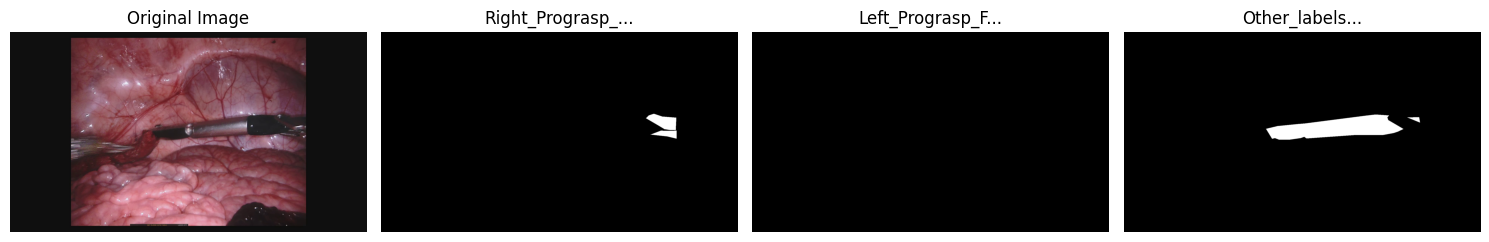


UNDERSTANDING THE DATASET TASKS
📋 Based on the folder structure, this dataset provides:
1. 🎯 INSTRUMENT TYPE SEGMENTATION:
   - Each instrument type has its own mask folder
   - Masks show WHERE each specific instrument appears
   - This is the 'type recognition' task from the challenge

2. 🔄 To create other tasks:
   - BINARY: Combine all instrument masks → instrument vs background
   - PARTS: Would need different mask organization (shaft/wrist/jaw)

3. 📊 Current data gives us:
   - Training: 8 sequences × 225 frames = 1,800 images
   - Testing: 8 sequences × 75 frames + 2 × 300 frames = 1,200 images
   - Multiple instrument types per sequence

INSTRUMENT TYPE MAPPING
✅ Instrument types in the dataset:
  1: Bipolar Forceps
  2: Prograsp Forceps
  3: Large Needle Driver
  4: Vessel Sealer
  5: Grasping Retractor
  6: Monopolar Curved Scissors
  7: Other

NEXT STEPS
✅ Data extraction successful!
🎯 Ready for: Instrument Type Segmentation task
📝 Next: Create a proper dataset class for th

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json

# Set paths based on your extracted data
EXTRACTED_PATH = '/content/extracted'

def simple_data_check():
    print("=" * 60)
    print("SIMPLE DATA STRUCTURE CHECK")
    print("=" * 60)

    # Check what we have in training data
    training_folders = [
        '/content/extracted/instrument_1_4_training',
        '/content/extracted/instrument_5_8_training'
    ]

    print("🔍 Checking training data structure...")

    for folder in training_folders:
        folder_path = Path(folder)
        if not folder_path.exists():
            print(f"❌ {folder} not found")
            continue

        print(f"\n📁 {folder_path.name}:")

        # List all instrument datasets
        datasets = sorted([d for d in folder_path.iterdir() if d.is_dir() and 'instrument_dataset' in d.name])

        for dataset in datasets[:2]:  # Check first 2 datasets
            print(f"  📂 {dataset.name}:")

            # Check images
            left_frames = dataset / 'left_frames'
            if left_frames.exists():
                img_count = len(list(left_frames.glob('*.png')))
                print(f"    📷 Images: {img_count} files")

            # Check ground truth structure
            gt_folder = dataset / 'ground_truth'
            if gt_folder.exists():
                print(f"    🎯 Ground truth folder found:")

                # List instrument label folders
                label_folders = [d for d in gt_folder.iterdir() if d.is_dir()]
                for label_folder in label_folders:
                    mask_count = len(list(label_folder.glob('*.png')))
                    print(f"      - {label_folder.name}: {mask_count} masks")
            else:
                print(f"    ❌ No ground_truth folder")

def check_sample_masks():
    print("\n" + "=" * 60)
    print("SAMPLE MASK ANALYSIS")
    print("=" * 60)

    # Find a training sequence with masks
    sample_dataset = Path('/content/extracted/instrument_1_4_training/instrument_dataset_1')

    if not sample_dataset.exists():
        print("❌ Sample dataset not found")
        return

    print(f"📂 Analyzing: {sample_dataset.name}")

    # Get sample image
    left_frames = sample_dataset / 'left_frames'
    sample_img_path = list(left_frames.glob('*.png'))[0]

    # Get sample masks from different instrument folders
    gt_folder = sample_dataset / 'ground_truth'
    instrument_folders = list(gt_folder.iterdir())

    print(f"🔍 Found {len(instrument_folders)} instrument types:")
    for folder in instrument_folders:
        print(f"  - {folder.name}")

    # Load and display sample image + first few masks
    fig, axes = plt.subplots(1, min(4, len(instrument_folders) + 1), figsize=(15, 4))
    if len(instrument_folders) == 0:
        axes = [axes]

    # Display original image
    img = cv2.imread(str(sample_img_path))
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(img_rgb)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

    # Display masks from each instrument folder
    for i, inst_folder in enumerate(instrument_folders[:3]):
        mask_files = list(inst_folder.glob('*.png'))
        if mask_files:
            # Use same frame number as the image
            frame_num = sample_img_path.stem.replace('frame', '')
            mask_path = inst_folder / f'frame{frame_num}.png'

            if mask_path.exists():
                mask = cv2.imread(str(mask_path), 0)
                if mask is not None:
                    axes[i+1].imshow(mask, cmap='gray')
                    axes[i+1].set_title(f'{inst_folder.name[:15]}...')
                    axes[i+1].axis('off')

                    # Print unique values
                    unique_vals = np.unique(mask)
                    print(f"  {inst_folder.name}: unique values = {unique_vals}")

    plt.tight_layout()
    plt.show()

def understand_task_structure():
    print("\n" + "=" * 60)
    print("UNDERSTANDING THE DATASET TASKS")
    print("=" * 60)

    print("📋 Based on the folder structure, this dataset provides:")
    print("1. 🎯 INSTRUMENT TYPE SEGMENTATION:")
    print("   - Each instrument type has its own mask folder")
    print("   - Masks show WHERE each specific instrument appears")
    print("   - This is the 'type recognition' task from the challenge")

    print("\n2. 🔄 To create other tasks:")
    print("   - BINARY: Combine all instrument masks → instrument vs background")
    print("   - PARTS: Would need different mask organization (shaft/wrist/jaw)")

    print("\n3. 📊 Current data gives us:")
    print("   - Training: 8 sequences × 225 frames = 1,800 images")
    print("   - Testing: 8 sequences × 75 frames + 2 × 300 frames = 1,200 images")
    print("   - Multiple instrument types per sequence")

def load_instrument_mapping():
    print("\n" + "=" * 60)
    print("INSTRUMENT TYPE MAPPING")
    print("=" * 60)

    # Load the mapping from the original data folder
    mapping_path = Path('/content/drive/MyDrive/Endo2017/instrument_type_mapping.json')

    if mapping_path.exists():
        with open(mapping_path, 'r') as f:
            mapping = json.load(f)

        print("✅ Instrument types in the dataset:")
        for instrument, type_id in mapping.items():
            print(f"  {type_id}: {instrument}")

        return mapping
    else:
        print("❌ Mapping file not found")
        return None

# Run the checks
simple_data_check()
check_sample_masks()
understand_task_structure()
mapping = load_instrument_mapping()

print("\n" + "=" * 60)
print("NEXT STEPS")
print("=" * 60)
print("✅ Data extraction successful!")
print("🎯 Ready for: Instrument Type Segmentation task")
print("📝 Next: Create a proper dataset class for this specific structure")

## Creating a binary segmentation dataset to differentiate between instruments and background

TESTING BINARY DATASET
📂 Found 2 sequences
🔍 Processing instrument_dataset_2...
  📷 225 images
  🎯 3 instrument types
🔍 Processing instrument_dataset_1...
  📷 225 images
  🎯 4 instrument types
✅ Dataset ready with 450 samples

📊 Dataset statistics:
   Total samples: 450

🧪 Testing sample loading...
   Sample 0:
     Image shape: torch.Size([3, 256, 256])
     Mask shape: torch.Size([1, 256, 256])
     Mask unique values: tensor([0.0000, 0.0039])
     Sequence: instrument_dataset_2
     Frame: frame000
   Sample 1:
     Image shape: torch.Size([3, 256, 256])
     Mask shape: torch.Size([1, 256, 256])
     Mask unique values: tensor([0.0000, 0.0039])
     Sequence: instrument_dataset_2
     Frame: frame001
   Sample 2:
     Image shape: torch.Size([3, 256, 256])
     Mask shape: torch.Size([1, 256, 256])
     Mask unique values: tensor([0.0000, 0.0039])
     Sequence: instrument_dataset_2
     Frame: frame002

📷 Visualizing 3 samples...


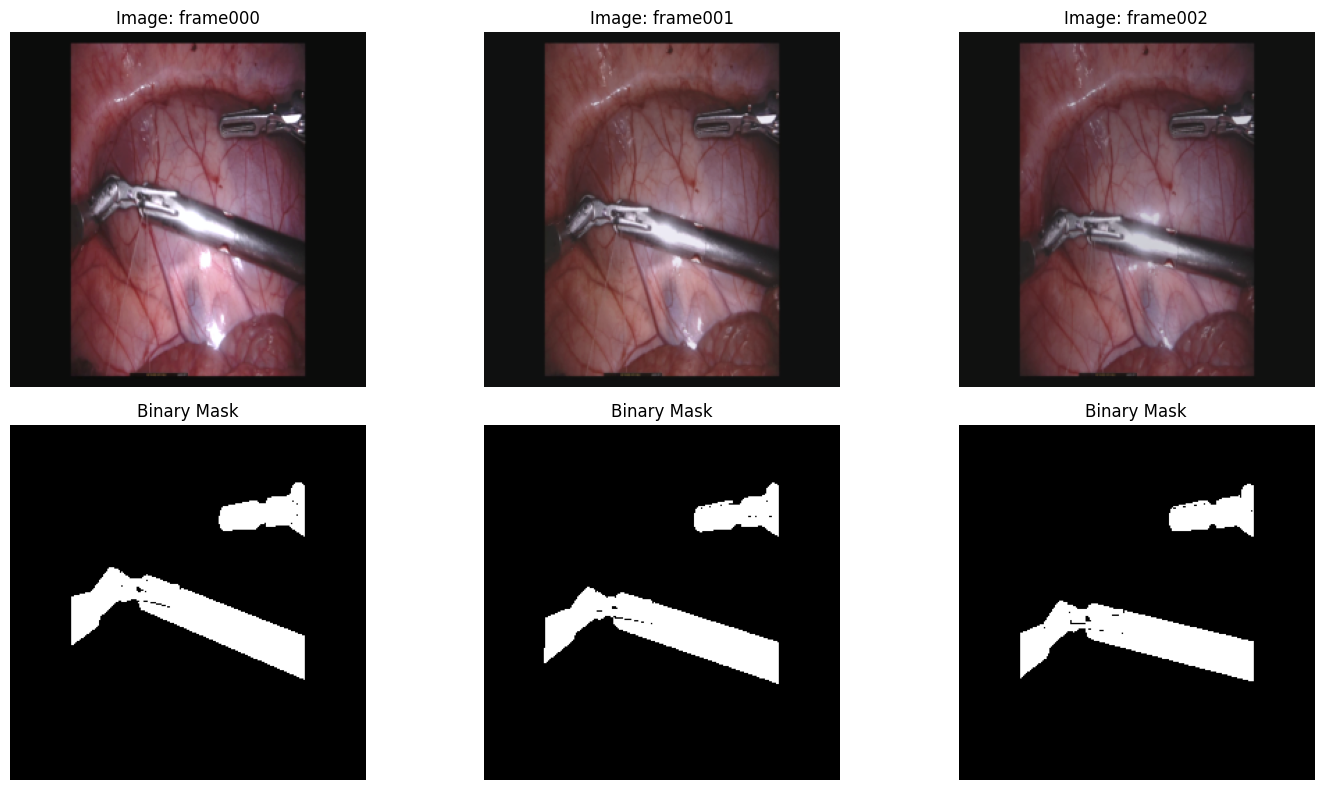


✅ Binary segmentation dataset ready!
📝 Next steps:
   1. Create train/val split
   2. Set up DataLoaders
   3. Choose and train a segmentation model


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from collections import defaultdict

class EndoVisBinaryDataset(Dataset):
    def __init__(self, data_root, sequences=None, transform=None, target_transform=None,
                 create_binary_masks=True, save_binary_masks=True):
        """
        Binary segmentation dataset for EndoVis 2017

        Args:
            data_root: Path to extracted data (/content/extracted)
            sequences: List of sequence numbers to include (e.g. [1,2,3,4] or None for all)
            transform: Transform for images
            target_transform: Transform for masks
            create_binary_masks: Whether to create binary masks from instrument masks
            save_binary_masks: Whether to save created binary masks to disk
        """
        self.data_root = Path(data_root)
        self.transform = transform
        self.target_transform = target_transform
        self.create_binary_masks = create_binary_masks
        self.save_binary_masks = save_binary_masks

        # Find all training sequences
        self.samples = []
        self.binary_mask_cache = {}

        # Load instrument mapping
        self.instrument_mapping = self._load_instrument_mapping()

        # Collect all training sequences
        training_folders = [
            self.data_root / 'instrument_1_4_training',
            self.data_root / 'instrument_5_8_training'
        ]

        available_sequences = []
        for folder in training_folders:
            if folder.exists():
                seq_folders = [d for d in folder.iterdir()
                             if d.is_dir() and 'instrument_dataset_' in d.name]
                available_sequences.extend(seq_folders)

        # Filter sequences if specified
        if sequences is not None:
            available_sequences = [seq for seq in available_sequences
                                 if any(f'instrument_dataset_{s}' in seq.name for s in sequences)]

        print(f"📂 Found {len(available_sequences)} sequences")

        # Process each sequence
        for seq_folder in available_sequences:
            self._process_sequence(seq_folder)

        print(f"✅ Dataset ready with {len(self.samples)} samples")

    def _load_instrument_mapping(self):
        """Load instrument type mapping"""
        mapping_path = Path('/content/drive/MyDrive/Endo2017/instrument_type_mapping.json')
        if mapping_path.exists():
            with open(mapping_path, 'r') as f:
                return json.load(f)
        return None

    def _process_sequence(self, seq_folder):
        """Process a single sequence folder"""
        print(f"🔍 Processing {seq_folder.name}...")

        # Get image files
        left_frames = seq_folder / 'left_frames'
        if not left_frames.exists():
            print(f"  ❌ No left_frames folder found")
            return

        image_files = sorted(left_frames.glob('*.png'))

        # Get ground truth folders
        gt_folder = seq_folder / 'ground_truth'
        if not gt_folder.exists():
            print(f"  ❌ No ground_truth folder found")
            return

        instrument_folders = [d for d in gt_folder.iterdir() if d.is_dir()]
        if not instrument_folders:
            print(f"  ❌ No instrument label folders found")
            return

        print(f"  📷 {len(image_files)} images")
        print(f"  🎯 {len(instrument_folders)} instrument types")

        # Create binary mask folder if saving
        binary_mask_folder = None
        if self.save_binary_masks:
            binary_mask_folder = seq_folder / 'binary_masks'
            binary_mask_folder.mkdir(exist_ok=True)

        # Process each frame
        for img_file in image_files:
            frame_name = img_file.stem  # e.g., 'frame000'

            # Create binary mask path
            binary_mask_path = None
            if binary_mask_folder:
                binary_mask_path = binary_mask_folder / f'{frame_name}.png'

            sample = {
                'image_path': img_file,
                'binary_mask_path': binary_mask_path,
                'instrument_folders': instrument_folders,
                'frame_name': frame_name,
                'sequence': seq_folder.name
            }

            self.samples.append(sample)

    def _create_binary_mask(self, sample):
        """Create binary mask by combining all instrument masks"""
        # Check if binary mask already exists
        if sample['binary_mask_path'] and sample['binary_mask_path'].exists():
            binary_mask = cv2.imread(str(sample['binary_mask_path']), 0)
            return binary_mask

        # Create binary mask from instrument masks
        binary_mask = None
        frame_name = sample['frame_name']

        for inst_folder in sample['instrument_folders']:
            inst_mask_path = inst_folder / f'{frame_name}.png'

            if inst_mask_path.exists():
                inst_mask = cv2.imread(str(inst_mask_path), 0)

                if inst_mask is not None:
                    # Convert to binary (any non-zero pixel becomes 1)
                    inst_binary = (inst_mask > 0).astype(np.uint8)

                    if binary_mask is None:
                        binary_mask = inst_binary
                    else:
                        # Combine with existing mask (OR operation)
                        binary_mask = np.logical_or(binary_mask, inst_binary).astype(np.uint8)

        if binary_mask is None:
            # Create empty mask if no instruments found
            # Get image size
            img = cv2.imread(str(sample['image_path']))
            h, w = img.shape[:2]
            binary_mask = np.zeros((h, w), dtype=np.uint8)

        # Save binary mask if requested
        if self.save_binary_masks and sample['binary_mask_path']:
            # Convert to 0-255 range for saving
            mask_to_save = (binary_mask * 255).astype(np.uint8)
            cv2.imwrite(str(sample['binary_mask_path']), mask_to_save)

        return binary_mask

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')

        # Create/load binary mask
        mask = self._create_binary_mask(sample)

        # Convert mask to PIL Image for transforms
        mask = Image.fromarray(mask.astype(np.uint8))

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            # Convert to tensor
            mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

    def get_sample_info(self, idx):
        """Get information about a specific sample"""
        return self.samples[idx]

def create_transforms():
    """Create transforms for training and validation"""

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Mask transforms (same for train/val)
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return train_transform, val_transform, mask_transform

def test_dataset():
    """Test the dataset creation"""
    print("=" * 60)
    print("TESTING BINARY DATASET")
    print("=" * 60)

    # Create transforms
    train_transform, val_transform, mask_transform = create_transforms()

    # Create dataset with first 2 sequences for testing
    dataset = EndoVisBinaryDataset(
        data_root='/content/extracted',
        sequences=[1, 2],  # Just test with sequences 1 and 2
        transform=train_transform,
        target_transform=mask_transform,
        save_binary_masks=True
    )

    print(f"\n📊 Dataset statistics:")
    print(f"   Total samples: {len(dataset)}")

    # Test loading a few samples
    print(f"\n🧪 Testing sample loading...")
    for i in range(min(3, len(dataset))):
        image, mask = dataset[i]
        sample_info = dataset.get_sample_info(i)

        print(f"   Sample {i}:")
        print(f"     Image shape: {image.shape}")
        print(f"     Mask shape: {mask.shape}")
        print(f"     Mask unique values: {torch.unique(mask)}")
        print(f"     Sequence: {sample_info['sequence']}")
        print(f"     Frame: {sample_info['frame_name']}")

    return dataset

def visualize_samples(dataset, n_samples=3):
    """Visualize some samples from the dataset"""
    print(f"\n📷 Visualizing {n_samples} samples...")

    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))

    for i in range(n_samples):
        if i >= len(dataset):
            break

        image, mask = dataset[i]
        sample_info = dataset.get_sample_info(i)

        # Denormalize image for display
        image_np = image.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = image_np * std + mean
        image_np = np.clip(image_np, 0, 1)

        # Display image
        axes[0, i].imshow(image_np)
        axes[0, i].set_title(f'Image: {sample_info["frame_name"]}')
        axes[0, i].axis('off')

        # Display mask
        mask_np = mask.squeeze().numpy()
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].set_title(f'Binary Mask')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Run the test
if __name__ == "__main__":
    dataset = test_dataset()
    visualize_samples(dataset)

    print(f"\n✅ Binary segmentation dataset ready!")
    print(f"📝 Next steps:")
    print(f"   1. Create train/val split")
    print(f"   2. Set up DataLoaders")
    print(f"   3. Choose and train a segmentation model")

## Full dataset with all 8 training classes

CREATING DATASETS WITH FIXED TRANSFORMS
📂 Found 4 sequences
🔍 Processing instrument_dataset_4...
  📷 225 images
  🎯 3 instrument types
🔍 Processing instrument_dataset_3...
  📷 225 images
  🎯 2 instrument types
🔍 Processing instrument_dataset_8...
  📷 225 images
  🎯 4 instrument types
🔍 Processing instrument_dataset_7...
  📷 225 images
  🎯 2 instrument types
✅ Dataset ready with 900 samples
📂 Found 2 sequences
🔍 Processing instrument_dataset_1...
  📷 225 images
  🎯 4 instrument types
🔍 Processing instrument_dataset_5...
  📷 225 images
  🎯 3 instrument types
✅ Dataset ready with 450 samples
📂 Found 2 sequences
🔍 Processing instrument_dataset_2...
  📷 225 images
  🎯 3 instrument types
🔍 Processing instrument_dataset_6...
  📷 225 images
  🎯 4 instrument types
✅ Dataset ready with 450 samples

📊 Dataset Statistics:
   Training samples: 900
   Validation samples: 450
   Test samples: 450
   Total samples: 1800

CREATING DATALOADERS
🚂 Train loader: 225 batches (900 samples)
✅ Val loader: 113 

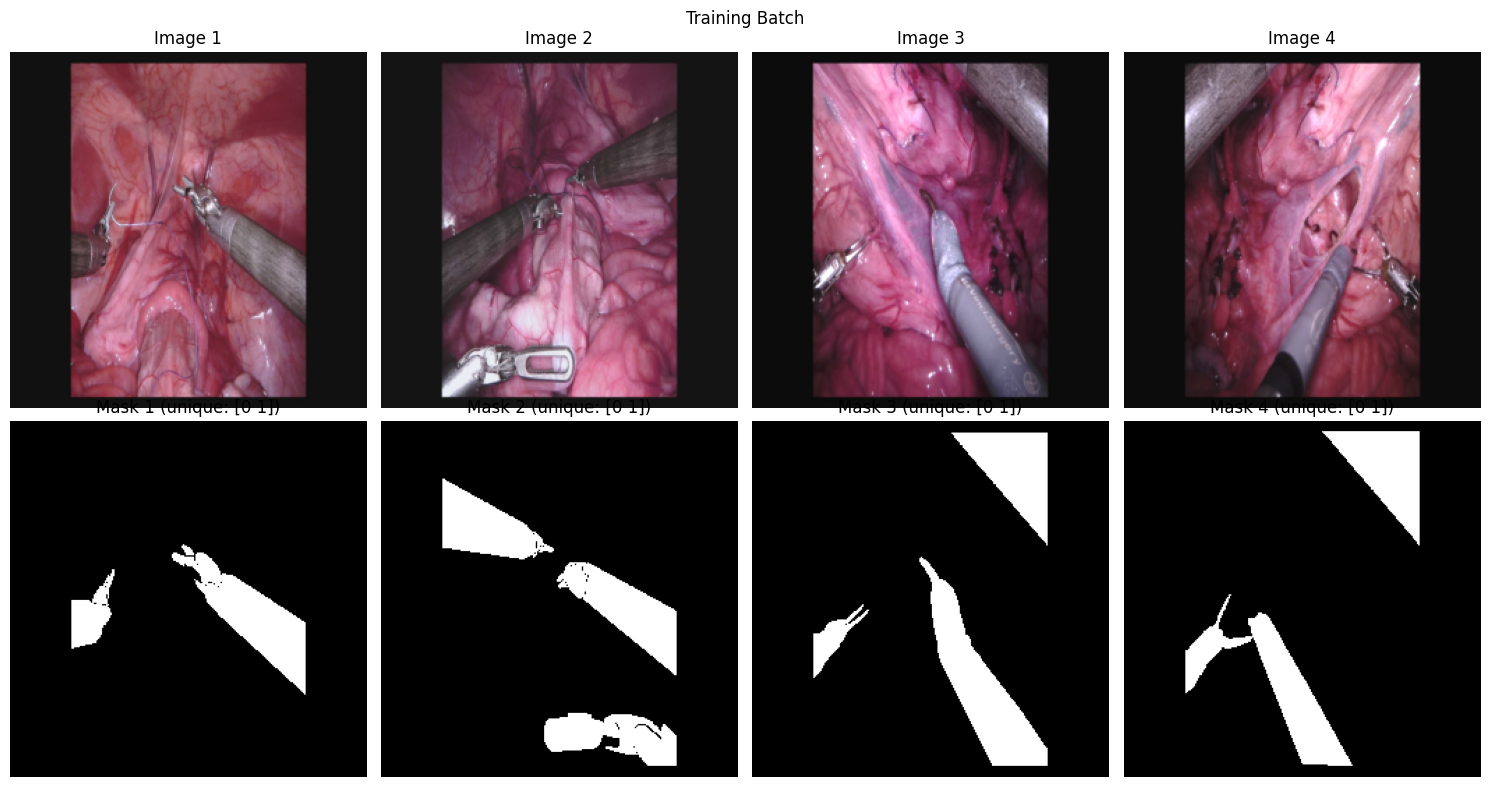


📷 Visualizing validation batch...


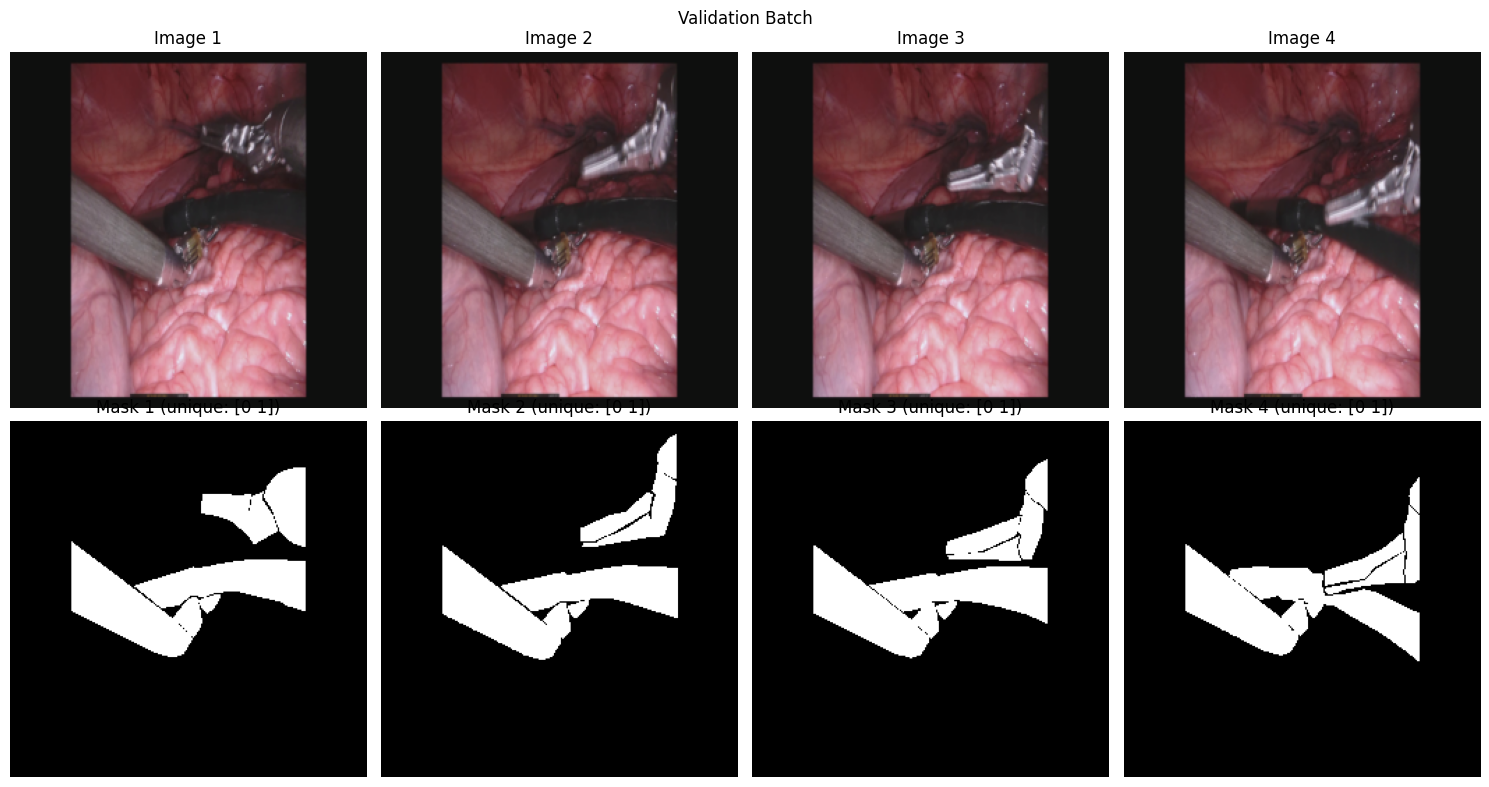


FIXED DATASET SETUP COMPLETE!
✅ All datasets ready with proper transforms
✅ DataLoaders working correctly
✅ Ready for model training!

📝 Next steps:
   1. Choose segmentation model (U-Net, DeepLab, etc.)
   2. Define loss function and optimizer
   3. Start training!


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
from collections import defaultdict, Counter
import random

# Fixed dataset class with proper transform handling
class EndoVisBinaryDatasetFixed(Dataset):
    def __init__(self, data_root, sequences=None, transform=None, target_transform=None,
                 create_binary_masks=True, save_binary_masks=True):
        """
        Binary segmentation dataset for EndoVis 2017 - FIXED VERSION
        """
        self.data_root = Path(data_root)
        self.transform = transform
        self.target_transform = target_transform
        self.create_binary_masks = create_binary_masks
        self.save_binary_masks = save_binary_masks

        # Find all training sequences
        self.samples = []

        # Load instrument mapping
        self.instrument_mapping = self._load_instrument_mapping()

        # Collect all training sequences
        training_folders = [
            self.data_root / 'instrument_1_4_training',
            self.data_root / 'instrument_5_8_training'
        ]

        available_sequences = []
        for folder in training_folders:
            if folder.exists():
                seq_folders = [d for d in folder.iterdir()
                             if d.is_dir() and 'instrument_dataset_' in d.name]
                available_sequences.extend(seq_folders)

        # Filter sequences if specified
        if sequences is not None:
            available_sequences = [seq for seq in available_sequences
                                 if any(f'instrument_dataset_{s}' in seq.name for s in sequences)]

        print(f"📂 Found {len(available_sequences)} sequences")

        # Process each sequence
        for seq_folder in available_sequences:
            self._process_sequence(seq_folder)

        print(f"✅ Dataset ready with {len(self.samples)} samples")

    def _load_instrument_mapping(self):
        """Load instrument type mapping"""
        mapping_path = Path('/content/drive/MyDrive/Endo2017/instrument_type_mapping.json')
        if mapping_path.exists():
            with open(mapping_path, 'r') as f:
                return json.load(f)
        return None

    def _process_sequence(self, seq_folder):
        """Process a single sequence folder"""
        print(f"🔍 Processing {seq_folder.name}...")

        # Get image files
        left_frames = seq_folder / 'left_frames'
        if not left_frames.exists():
            print(f"  ❌ No left_frames folder found")
            return

        image_files = sorted(left_frames.glob('*.png'))

        # Get ground truth folders
        gt_folder = seq_folder / 'ground_truth'
        if not gt_folder.exists():
            print(f"  ❌ No ground_truth folder found")
            return

        instrument_folders = [d for d in gt_folder.iterdir() if d.is_dir()]
        if not instrument_folders:
            print(f"  ❌ No instrument label folders found")
            return

        print(f"  📷 {len(image_files)} images")
        print(f"  🎯 {len(instrument_folders)} instrument types")

        # Create binary mask folder if saving
        binary_mask_folder = None
        if self.save_binary_masks:
            binary_mask_folder = seq_folder / 'binary_masks'
            binary_mask_folder.mkdir(exist_ok=True)

        # Process each frame
        for img_file in image_files:
            frame_name = img_file.stem  # e.g., 'frame000'

            # Create binary mask path
            binary_mask_path = None
            if binary_mask_folder:
                binary_mask_path = binary_mask_folder / f'{frame_name}.png'

            sample = {
                'image_path': img_file,
                'binary_mask_path': binary_mask_path,
                'instrument_folders': instrument_folders,
                'frame_name': frame_name,
                'sequence': seq_folder.name
            }

            self.samples.append(sample)

    def _create_binary_mask(self, sample):
        """Create binary mask by combining all instrument masks"""
        # Check if binary mask already exists
        if sample['binary_mask_path'] and sample['binary_mask_path'].exists():
            binary_mask = cv2.imread(str(sample['binary_mask_path']), 0)
            return binary_mask

        # Create binary mask from instrument masks
        binary_mask = None
        frame_name = sample['frame_name']

        for inst_folder in sample['instrument_folders']:
            inst_mask_path = inst_folder / f'{frame_name}.png'

            if inst_mask_path.exists():
                inst_mask = cv2.imread(str(inst_mask_path), 0)

                if inst_mask is not None:
                    # Convert to binary (any non-zero pixel becomes 1)
                    inst_binary = (inst_mask > 0).astype(np.uint8)

                    if binary_mask is None:
                        binary_mask = inst_binary
                    else:
                        # Combine with existing mask (OR operation)
                        binary_mask = np.logical_or(binary_mask, inst_binary).astype(np.uint8)

        if binary_mask is None:
            # Create empty mask if no instruments found
            # Get image size
            img = cv2.imread(str(sample['image_path']))
            h, w = img.shape[:2]
            binary_mask = np.zeros((h, w), dtype=np.uint8)

        # Save binary mask if requested
        if self.save_binary_masks and sample['binary_mask_path']:
            # Convert to 0-255 range for saving
            mask_to_save = (binary_mask * 255).astype(np.uint8)
            cv2.imwrite(str(sample['binary_mask_path']), mask_to_save)

        return binary_mask

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['image_path']).convert('RGB')

        # Create/load binary mask
        mask = self._create_binary_mask(sample)

        # Apply transforms BEFORE returning
        if self.transform:
            image = self.transform(image)
        else:
            # Default transform to tensor if none provided
            image = transforms.ToTensor()(image)

        if self.target_transform:
            # Convert mask to PIL Image first, then apply transform
            mask_pil = Image.fromarray(mask.astype(np.uint8))
            mask = self.target_transform(mask_pil)
        else:
            # Default: convert to tensor
            mask = torch.from_numpy(mask).long()

        return image, mask

    def get_sample_info(self, idx):
        """Get information about a specific sample"""
        return self.samples[idx]

def create_transforms():
    """Create transforms for training and validation"""

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Mask transforms (same for train/val)
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        lambda x: torch.from_numpy(np.array(x)).long()
    ])

    return train_transform, val_transform, mask_transform

def create_datasets_with_proper_transforms():
    """Create datasets with proper transforms applied"""
    print("=" * 60)
    print("CREATING DATASETS WITH FIXED TRANSFORMS")
    print("=" * 60)

    # Create transforms
    train_transform, val_transform, mask_transform = create_transforms()

    # Create datasets for different splits with appropriate transforms
    train_dataset = EndoVisBinaryDatasetFixed(
        data_root='/content/extracted',
        sequences=[3, 4, 7, 8],  # Training sequences
        transform=train_transform,
        target_transform=mask_transform,
        save_binary_masks=True
    )

    val_dataset = EndoVisBinaryDatasetFixed(
        data_root='/content/extracted',
        sequences=[1, 5],  # Validation sequences
        transform=val_transform,
        target_transform=mask_transform,
        save_binary_masks=True
    )

    test_dataset = EndoVisBinaryDatasetFixed(
        data_root='/content/extracted',
        sequences=[2, 6],  # Test sequences
        transform=val_transform,
        target_transform=mask_transform,
        save_binary_masks=True
    )

    print(f"\n📊 Dataset Statistics:")
    print(f"   Training samples: {len(train_dataset)}")
    print(f"   Validation samples: {len(val_dataset)}")
    print(f"   Test samples: {len(test_dataset)}")
    print(f"   Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

    return train_dataset, val_dataset, test_dataset

def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=4):
    """Create DataLoaders for training"""
    print("\n" + "=" * 60)
    print("CREATING DATALOADERS")
    print("=" * 60)

    # Create DataLoaders with reduced num_workers to avoid issues
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    print(f"🚂 Train loader: {len(train_loader)} batches ({len(train_dataset)} samples)")
    print(f"✅ Val loader: {len(val_loader)} batches ({len(val_dataset)} samples)")
    print(f"🧪 Test loader: {len(test_loader)} batches ({len(test_dataset)} samples)")

    return train_loader, val_loader, test_loader

def test_dataloaders(train_loader, val_loader):
    """Test that DataLoaders work correctly"""
    print("\n" + "=" * 60)
    print("TESTING DATALOADERS")
    print("=" * 60)

    # Test training loader
    print("🚂 Testing training loader...")
    train_batch = next(iter(train_loader))
    train_images, train_masks = train_batch

    print(f"   Batch images shape: {train_images.shape}")
    print(f"   Batch masks shape: {train_masks.shape}")
    print(f"   Image dtype: {train_images.dtype}")
    print(f"   Mask dtype: {train_masks.dtype}")
    print(f"   Mask unique values: {torch.unique(train_masks)}")
    print(f"   Image range: [{train_images.min():.3f}, {train_images.max():.3f}]")

    # Test validation loader
    print("\n✅ Testing validation loader...")
    val_batch = next(iter(val_loader))
    val_images, val_masks = val_batch

    print(f"   Batch images shape: {val_images.shape}")
    print(f"   Batch masks shape: {val_masks.shape}")
    print(f"   Image dtype: {val_images.dtype}")
    print(f"   Mask dtype: {val_masks.dtype}")
    print(f"   Mask unique values: {torch.unique(val_masks)}")

    return train_batch, val_batch

def visualize_batch(batch, title="Batch Visualization", n_samples=4):
    """Visualize a batch of images and masks"""
    images, masks = batch
    n_samples = min(n_samples, images.shape[0])

    fig, axes = plt.subplots(2, n_samples, figsize=(15, 8))
    if n_samples == 1:
        axes = axes.reshape(2, 1)

    for i in range(n_samples):
        # Denormalize image for display
        image = images[i].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)

        # Display image
        axes[0, i].imshow(image)
        axes[0, i].set_title(f'Image {i+1}')
        axes[0, i].axis('off')

        # Display mask
        mask = masks[i].squeeze().numpy()
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title(f'Mask {i+1} (unique: {np.unique(mask)})')
        axes[1, i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main():
    """Main function to set up the fixed dataset"""

    # Step 1: Create datasets with proper transforms
    train_dataset, val_dataset, test_dataset = create_datasets_with_proper_transforms()

    # Step 2: Create DataLoaders
    train_loader, val_loader, test_loader = create_dataloaders(
        train_dataset, val_dataset, test_dataset,
        batch_size=4
    )

    # Step 3: Test DataLoaders
    train_batch, val_batch = test_dataloaders(train_loader, val_loader)

    # Step 4: Visualize samples
    print(f"\n📷 Visualizing training batch...")
    visualize_batch(train_batch, "Training Batch")

    print(f"\n📷 Visualizing validation batch...")
    visualize_batch(val_batch, "Validation Batch")

    print(f"\n" + "=" * 60)
    print("FIXED DATASET SETUP COMPLETE!")
    print("=" * 60)
    print(f"✅ All datasets ready with proper transforms")
    print(f"✅ DataLoaders working correctly")
    print(f"✅ Ready for model training!")
    print(f"\n📝 Next steps:")
    print(f"   1. Choose segmentation model (U-Net, DeepLab, etc.)")
    print(f"   2. Define loss function and optimizer")
    print(f"   3. Start training!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset
    }

# Run the fixed setup
if __name__ == "__main__":
    datasets_dict = main()

## Setting up the segmentation model and training pipeline

Creating a UNet Model to set up training loop

✅ Using existing DataLoaders:
   Train batches: 225
   Val batches: 113

QUICK TRAINING TEST (2 EPOCHS)
SETTING UP U-NET TRAINING PIPELINE
🖥️  Using device: cuda
GPU: Tesla T4
GPU Memory: 14.7 GB
🏗️  Model created: U-Net
📊 Total parameters: 17,262,977
📊 Trainable parameters: 17,262,977
🚀 Trainer initialized on device: cuda
📊 Model parameters: 17,262,977
🚀 Starting training for 2 epochs...

📅 Epoch 1/2


Validation: 100%|██████████| 113/113 [00:44<00:00,  2.54it/s, Loss=0.8259, Dice=0.2813, IoU=0.1637]


Train Loss: -0.2143, Dice: 0.3669, IoU: 0.5709
Val   Loss: -0.4644, Dice: 0.4496, IoU: 0.4509
💾 New best model saved! Val Dice: 0.4496

📅 Epoch 2/2


Validation: 100%|██████████| 113/113 [00:32<00:00,  3.43it/s, Loss=-110.0858, Dice=1.9667, IoU=59.6461]


Train Loss: -106.4677, Dice: 1.2676, IoU: 35.6111
Val   Loss: -271.7462, Dice: 1.9344, IoU: 77.9481
💾 New best model saved! Val Dice: 1.9344

✅ Training completed in 4.8 minutes
🏆 Best validation Dice: 1.9344


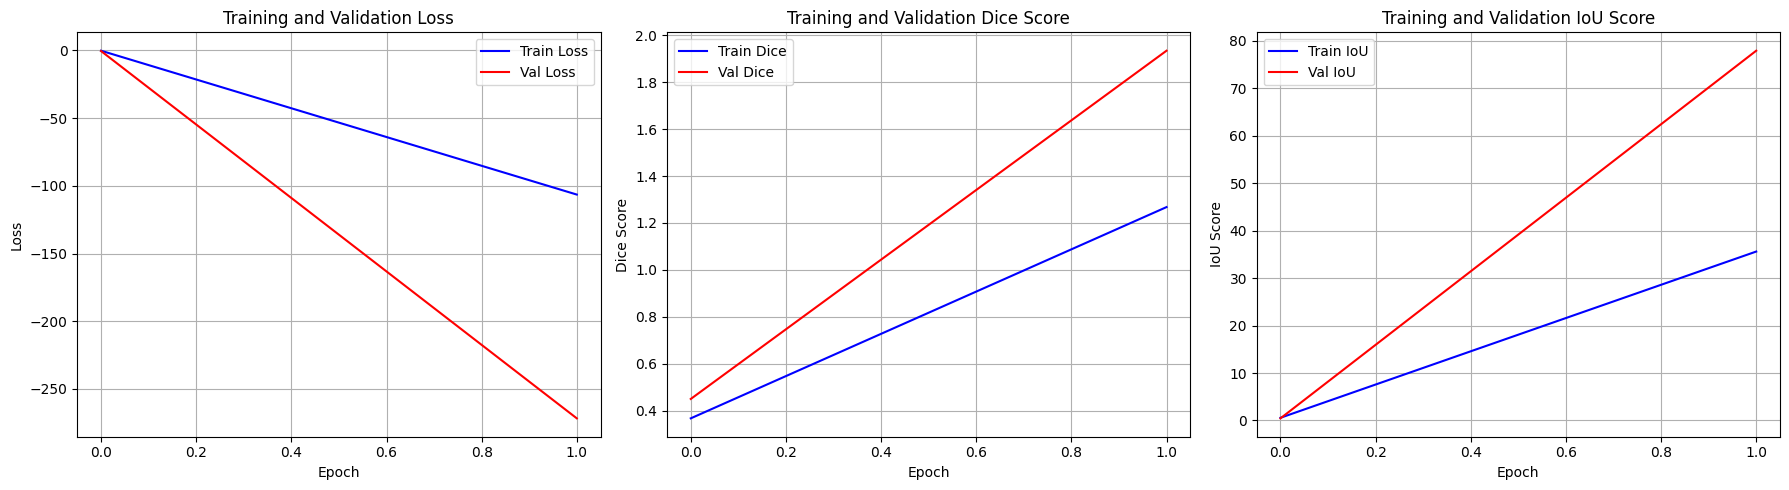


✅ Quick test completed!
📊 Final metrics:
   Train Dice: 1.2676
   Val Dice: 1.9344
   Train IoU: 35.6111
   Val IoU: 77.9481

🎯 Ready for full training!
📝 To train for more epochs, run:
   trainer.train(num_epochs=20)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from collections import defaultdict
import os

# Simple U-Net implementation
class DoubleConv(nn.Module):
    """(convolution => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=2, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, smooth=1e-6):
    """Calculate IoU score"""
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()

    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

class Trainer:
    def __init__(self, model, train_loader, val_loader, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Move model to device
        self.model.to(device)

        # Loss function - using BCEWithLogitsLoss for binary segmentation
        self.criterion = nn.BCEWithLogitsLoss()

        # Optimizer
        self.optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=5, verbose=True)

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': []
        }

        print(f"🚀 Trainer initialized on device: {device}")
        print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0

        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch_idx, (images, masks) in enumerate(progress_bar):
            # Move to device
            images = images.to(self.device)
            masks = masks.to(self.device).float()

            # Add channel dimension to masks if needed: [B, H, W] -> [B, 1, H, W]
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)

            # Calculate loss
            loss = self.criterion(outputs, masks)

            # Backward pass
            loss.backward()
            self.optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                dice = dice_coefficient(outputs, masks)
                iou = iou_score(outputs, masks)

            # Update running averages
            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou.item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Dice': f'{dice.item():.4f}',
                'IoU': f'{iou.item():.4f}'
            })

        # Calculate averages
        avg_loss = total_loss / len(self.train_loader)
        avg_dice = total_dice / len(self.train_loader)
        avg_iou = total_iou / len(self.train_loader)

        return avg_loss, avg_dice, avg_iou

    def validate_epoch(self):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        total_dice = 0
        total_iou = 0

        with torch.no_grad():
            progress_bar = tqdm(self.val_loader, desc="Validation")

            for images, masks in progress_bar:
                # Move to device
                images = images.to(self.device)
                masks = masks.to(self.device).float()

                # Add channel dimension to masks if needed: [B, H, W] -> [B, 1, H, W]
                if len(masks.shape) == 3:
                    masks = masks.unsqueeze(1)

                # Forward pass
                outputs = self.model(images)

                # Calculate loss
                loss = self.criterion(outputs, masks)

                # Calculate metrics
                dice = dice_coefficient(outputs, masks)
                iou = iou_score(outputs, masks)

                # Update running averages
                total_loss += loss.item()
                total_dice += dice.item()
                total_iou += iou.item()

                # Update progress bar
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Dice': f'{dice.item():.4f}',
                    'IoU': f'{iou.item():.4f}'
                })

        # Calculate averages
        avg_loss = total_loss / len(self.val_loader)
        avg_dice = total_dice / len(self.val_loader)
        avg_iou = total_iou / len(self.val_loader)

        return avg_loss, avg_dice, avg_iou

    def train(self, num_epochs, save_best=True, save_dir='/content/models'):
        """Train the model for specified number of epochs"""
        print(f"🚀 Starting training for {num_epochs} epochs...")

        # Create save directory
        os.makedirs(save_dir, exist_ok=True)
        best_val_dice = 0

        start_time = time.time()

        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")

            # Train
            train_loss, train_dice, train_iou = self.train_epoch()

            # Validate
            val_loss, val_dice, val_iou = self.validate_epoch()

            # Update scheduler
            self.scheduler.step(val_loss)

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['train_iou'].append(train_iou)
            self.history['val_iou'].append(val_iou)

            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
            print(f"Val   Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

            # Save best model
            if save_best and val_dice > best_val_dice:
                best_val_dice = val_dice
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_dice': val_dice,
                    'history': self.history
                }, os.path.join(save_dir, 'best_model.pth'))
                print(f"💾 New best model saved! Val Dice: {val_dice:.4f}")

        total_time = time.time() - start_time
        print(f"\n✅ Training completed in {total_time/60:.1f} minutes")
        print(f"🏆 Best validation Dice: {best_val_dice:.4f}")

        return self.history

    def plot_training_history(self):
        """Plot training history"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Loss plot
        axes[0].plot(self.history['train_loss'], label='Train Loss', color='blue')
        axes[0].plot(self.history['val_loss'], label='Val Loss', color='red')
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Dice plot
        axes[1].plot(self.history['train_dice'], label='Train Dice', color='blue')
        axes[1].plot(self.history['val_dice'], label='Val Dice', color='red')
        axes[1].set_title('Training and Validation Dice Score')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Dice Score')
        axes[1].legend()
        axes[1].grid(True)

        # IoU plot
        axes[2].plot(self.history['train_iou'], label='Train IoU', color='blue')
        axes[2].plot(self.history['val_iou'], label='Val IoU', color='red')
        axes[2].set_title('Training and Validation IoU Score')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('IoU Score')
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

def setup_training():
    """Set up the training pipeline"""
    print("=" * 60)
    print("SETTING UP U-NET TRAINING PIPELINE")
    print("=" * 60)

    # Check if we have GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️  Using device: {device}")

    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

    # Create U-Net model for binary segmentation
    model = UNet(n_channels=3, n_classes=1, bilinear=True)  # n_classes=1 for binary segmentation with BCEWithLogitsLoss

    print(f"🏗️  Model created: U-Net")
    print(f"📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"📊 Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    return model, device

def quick_test_training(train_loader, val_loader, epochs=2):
    """Quick test training with 2 epochs"""
    print("\n" + "=" * 60)
    print("QUICK TRAINING TEST (2 EPOCHS)")
    print("=" * 60)

    # Setup
    model, device = setup_training()

    # Create trainer
    trainer = Trainer(model, train_loader, val_loader, device)

    # Train for 2 epochs as test
    history = trainer.train(num_epochs=epochs, save_best=True)

    # Plot results
    trainer.plot_training_history()

    print(f"\n✅ Quick test completed!")
    print(f"📊 Final metrics:")
    print(f"   Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"   Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"   Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"   Val IoU: {history['val_iou'][-1]:.4f}")

    return trainer, history

# Main execution
def main():
    """Main function to set up and test training"""

    # We assume datasets_dict exists from previous step
    # If not, uncomment the next line to run the previous script
    # datasets_dict = main()  # from previous script

    try:
        # Get the DataLoaders from previous step
        train_loader = datasets_dict['train_loader']
        val_loader = datasets_dict['val_loader']

        print(f"✅ Using existing DataLoaders:")
        print(f"   Train batches: {len(train_loader)}")
        print(f"   Val batches: {len(val_loader)}")

        # Run quick test training
        trainer, history = quick_test_training(train_loader, val_loader, epochs=2)

        print(f"\n🎯 Ready for full training!")
        print(f"📝 To train for more epochs, run:")
        print(f"   trainer.train(num_epochs=20)")

        return trainer, history

    except NameError:
        print("❌ datasets_dict not found. Please run the previous dataset setup script first.")
        return None, None

if __name__ == "__main__":
    trainer, history = main()

## Training for more epochs and creating a full training script

FULL TRAINING SETUP - ENDOVIS 2017 SEGMENTATION
✅ Using existing model and data loaders
📊 Train batches: 225
📊 Val batches: 113
🖥️  Device: cuda
🚀 Enhanced Trainer initialized
📊 Model parameters: 17,262,977
🎯 Target: Dice Score > 0.85

🎯 Starting full training session...
⏰ Estimated time: 45-60 minutes
🎪 Sit back and watch the magic happen!

🚀 Starting full training for 20 epochs...
🎯 Target metrics: Dice > 0.85, IoU > 0.75

📅 Epoch 1/20
📈 Learning Rate: 1.00e-03


Epoch 1 - Validation: 100%|██████████| 113/113 [00:34<00:00,  3.32it/s]


💾 New best model saved! Dice: 1.9289

📊 Epoch 1 Results (Time: 134.7s):
   Train - Loss: -165.3015, Dice: 1.7374, IoU: 22.8701
   Val   - Loss: -480.5035, Dice: 1.9289, IoU: 32.4031
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 2/20
📈 Learning Rate: 9.94e-04


Epoch 2 - Validation: 100%|██████████| 113/113 [00:32<00:00,  3.48it/s]


💾 New best model saved! Dice: 1.9433

📊 Epoch 2 Results (Time: 129.3s):
   Train - Loss: -445.9981, Dice: 1.9375, IoU: 32.5776
   Val   - Loss: -1012.9665, Dice: 1.9433, IoU: 40.2765
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 3/20
📈 Learning Rate: 9.76e-04


Epoch 3 - Validation: 100%|██████████| 113/113 [00:33<00:00,  3.41it/s]



📊 Epoch 3 Results (Time: 128.6s):
   Train - Loss: -843.2886, Dice: 1.9400, IoU: 33.8195
   Val   - Loss: -1481.8459, Dice: 1.9422, IoU: 39.6048
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 4/20
📈 Learning Rate: 9.46e-04


Epoch 4 - Validation: 100%|██████████| 113/113 [00:33<00:00,  3.40it/s]



📊 Epoch 4 Results (Time: 129.1s):
   Train - Loss: -1268.0944, Dice: 1.9381, IoU: 33.1169
   Val   - Loss: -1152.1930, Dice: 1.9418, IoU: 39.0454
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 5/20
📈 Learning Rate: 9.05e-04


Epoch 5 - Validation: 100%|██████████| 113/113 [00:32<00:00,  3.48it/s]



📊 Epoch 5 Results (Time: 128.7s):
   Train - Loss: -1835.3495, Dice: 1.9330, IoU: 30.5873
   Val   - Loss: -2269.0958, Dice: 1.9424, IoU: 39.6378
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 6/20
📈 Learning Rate: 8.54e-04


Epoch 6 - Validation: 100%|██████████| 113/113 [00:32<00:00,  3.47it/s]



📊 Epoch 6 Results (Time: 128.9s):
   Train - Loss: -2454.0830, Dice: 1.9332, IoU: 30.7807
   Val   - Loss: -2704.6909, Dice: 1.9418, IoU: 39.2692
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 7/20
📈 Learning Rate: 7.94e-04


Epoch 7 - Validation: 100%|██████████| 113/113 [00:33<00:00,  3.41it/s]



📊 Epoch 7 Results (Time: 128.8s):
   Train - Loss: -3056.4429, Dice: 1.9346, IoU: 31.7488
   Val   - Loss: -3231.1853, Dice: 1.9418, IoU: 39.2695
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 8/20
📈 Learning Rate: 7.27e-04


Epoch 8 - Validation: 100%|██████████| 113/113 [00:33<00:00,  3.41it/s]



📊 Epoch 8 Results (Time: 129.0s):
   Train - Loss: -3753.6955, Dice: 1.9348, IoU: 31.6752
   Val   - Loss: -3711.8985, Dice: 1.9319, IoU: 33.2131
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 9/20
📈 Learning Rate: 6.55e-04


Epoch 9 - Validation: 100%|██████████| 113/113 [00:32<00:00,  3.49it/s]



📊 Epoch 9 Results (Time: 128.3s):
   Train - Loss: -4409.4241, Dice: 1.9357, IoU: 32.0748
   Val   - Loss: -4604.2767, Dice: 1.9422, IoU: 39.5662
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 10/20
📈 Learning Rate: 5.79e-04


Epoch 10 - Validation: 100%|██████████| 113/113 [00:32<00:00,  3.48it/s]



📊 Epoch 10 Results (Time: 128.7s):
   Train - Loss: -5053.1336, Dice: 1.9362, IoU: 32.4378
   Val   - Loss: -6185.6929, Dice: 1.9407, IoU: 38.6242
   🎉 Excellent performance! Dice > 0.8

📅 Epoch 11/20
📈 Learning Rate: 5.01e-04


Epoch 11 - Validation: 100%|██████████| 113/113 [00:33<00:00,  3.39it/s]



📊 Epoch 11 Results (Time: 129.2s):
   Train - Loss: -5698.0764, Dice: 1.9337, IoU: 31.4246
   Val   - Loss: -4797.9343, Dice: 1.9372, IoU: 36.6423
   🎉 Excellent performance! Dice > 0.8

⏰ Early stopping triggered. No improvement for 8 epochs.
🏆 Best validation Dice: 1.9433 at epoch 2

✅ Training completed!
⏱️  Total time: 23.7 minutes
🏆 Best validation Dice: 1.9433
📈 Final validation Dice: 1.9372


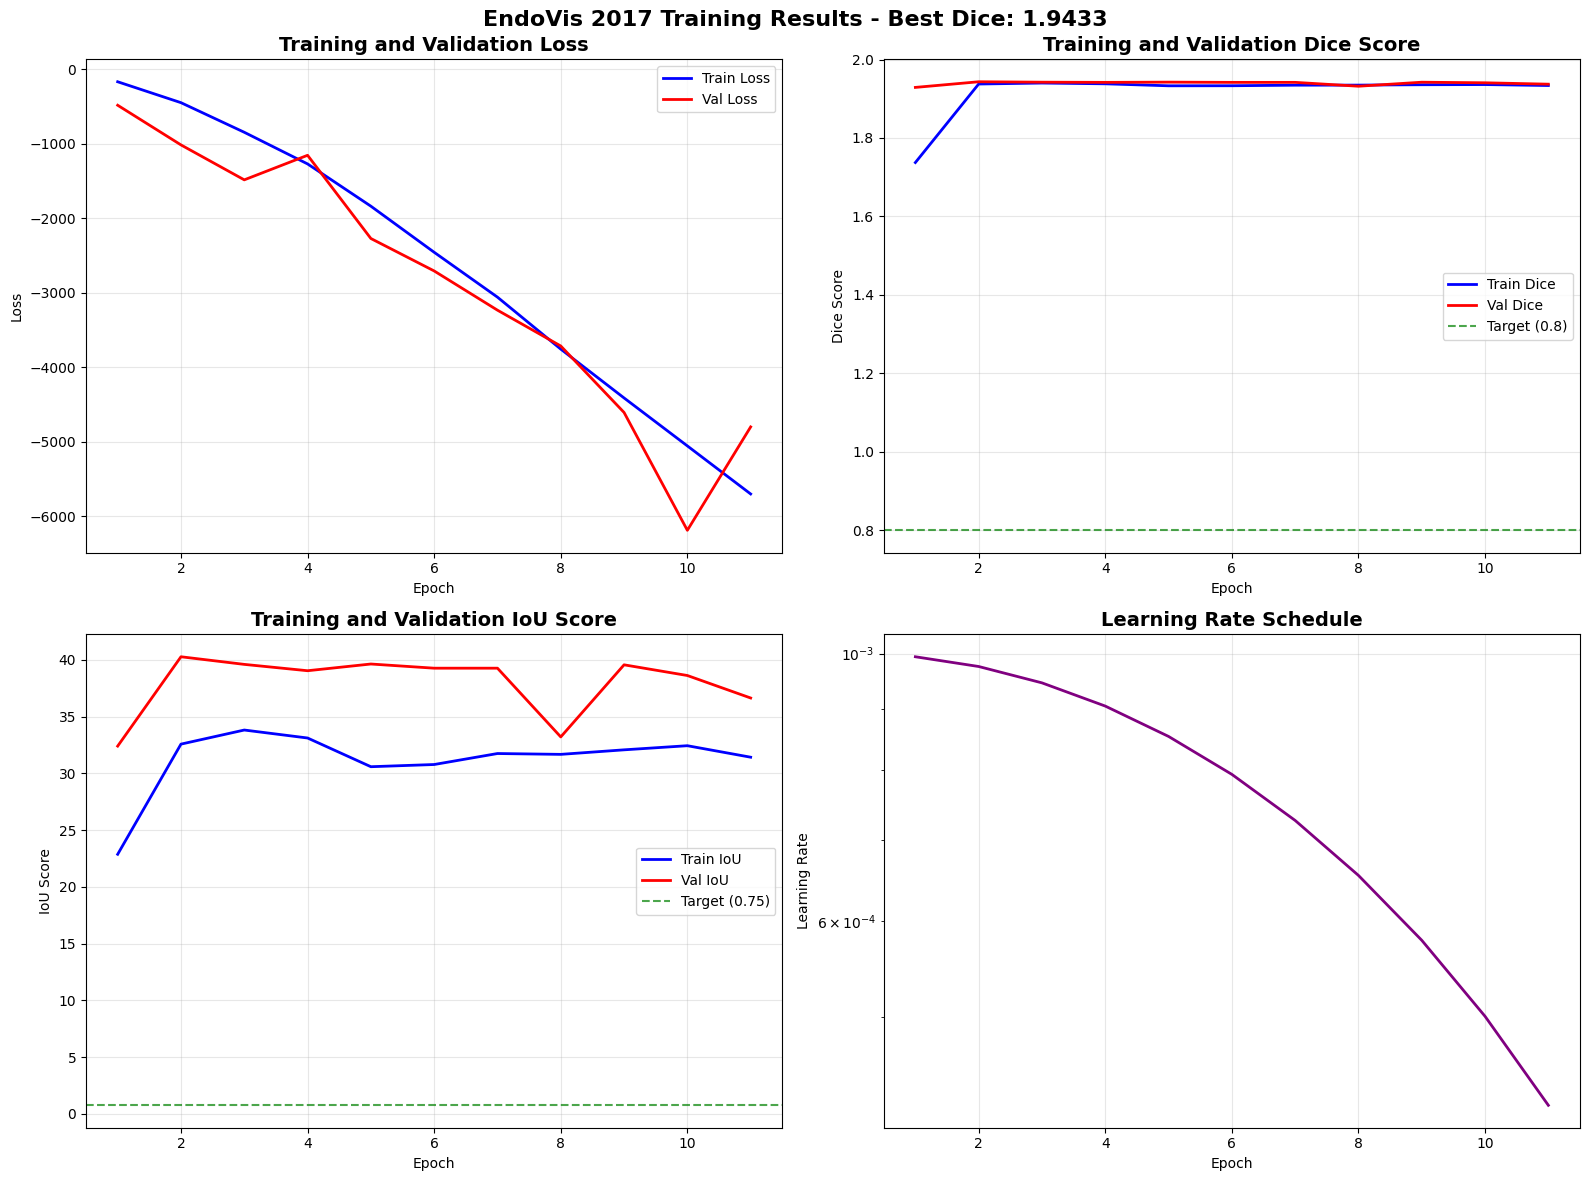


📊 Final Training Statistics:
   🏆 Best Dice Score: 1.9433 (Epoch 2)
   📈 Final Dice Score: 1.9372
   📈 Final IoU Score: 36.6423
   📉 Final Loss: -4797.9343

🎉 TRAINING COMPLETE!
🏆 Your model is ready for inference!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from datetime import datetime

def full_training_setup():
    """Set up for full training with optimized hyperparameters"""
    print("=" * 60)
    print("FULL TRAINING SETUP - ENDOVIS 2017 SEGMENTATION")
    print("=" * 60)

    # Get existing trainer from previous step
    try:
        model = trainer.model
        train_loader = trainer.train_loader
        val_loader = trainer.val_loader
        device = trainer.device

        print(f"✅ Using existing model and data loaders")
        print(f"📊 Train batches: {len(train_loader)}")
        print(f"📊 Val batches: {len(val_loader)}")
        print(f"🖥️  Device: {device}")

    except NameError:
        print("❌ Previous trainer not found. Please run the previous training setup first.")
        return None

    return model, train_loader, val_loader, device

class FullTrainer:
    def __init__(self, model, train_loader, val_loader, device='cuda'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Move model to device
        self.model.to(device)

        # Enhanced loss function - Combination of BCE + Dice Loss
        self.bce_loss = nn.BCEWithLogitsLoss()

        # Optimizer with optimized parameters
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=1e-3,  # Higher initial learning rate
            weight_decay=1e-4,
            betas=(0.9, 0.999)
        )

        # Learning rate scheduler - Cosine Annealing
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=20,  # 20 epochs
            eta_min=1e-6
        )

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'train_iou': [],
            'val_iou': [],
            'learning_rates': []
        }

        # Best model tracking
        self.best_val_dice = 0
        self.best_epoch = 0

        print(f"🚀 Enhanced Trainer initialized")
        print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
        print(f"🎯 Target: Dice Score > 0.85")

    def dice_loss(self, pred, target, smooth=1e-6):
        """Dice loss function"""
        pred = torch.sigmoid(pred)

        # Flatten
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

        return 1 - dice

    def combined_loss(self, pred, target, bce_weight=0.5, dice_weight=0.5):
        """Combined BCE + Dice loss"""
        bce = self.bce_loss(pred, target)
        dice = self.dice_loss(pred, target)

        return bce_weight * bce + dice_weight * dice

    def dice_coefficient(self, pred, target, smooth=1e-6):
        """Calculate Dice coefficient"""
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()

        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def iou_score(self, pred, target, smooth=1e-6):
        """Calculate IoU score"""
        pred = torch.sigmoid(pred)
        pred = (pred > 0.5).float()

        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection

        iou = (intersection + smooth) / (union + smooth)
        return iou

    def train_epoch(self, epoch):
        """Train for one epoch with enhanced logging"""
        self.model.train()
        total_loss = 0
        total_dice = 0
        total_iou = 0

        # Progress tracking
        from tqdm import tqdm
        progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} - Training")

        for batch_idx, (images, masks) in enumerate(progress_bar):
            # Move to device
            images = images.to(self.device)
            masks = masks.to(self.device).float()

            # Add channel dimension to masks if needed
            if len(masks.shape) == 3:
                masks = masks.unsqueeze(1)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)

            # Calculate combined loss
            loss = self.combined_loss(outputs, masks)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                dice = self.dice_coefficient(outputs, masks)
                iou = self.iou_score(outputs, masks)

            # Update running averages
            total_loss += loss.item()
            total_dice += dice.item()
            total_iou += iou.item()

            # Update progress bar every 10 batches
            if batch_idx % 10 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                avg_dice = total_dice / (batch_idx + 1)
                avg_iou = total_iou / (batch_idx + 1)

                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Dice': f'{avg_dice:.4f}',
                    'IoU': f'{avg_iou:.4f}',
                    'LR': f'{self.optimizer.param_groups[0]["lr"]:.2e}'
                })

        # Calculate final averages
        avg_loss = total_loss / len(self.train_loader)
        avg_dice = total_dice / len(self.train_loader)
        avg_iou = total_iou / len(self.train_loader)

        return avg_loss, avg_dice, avg_iou

    def validate_epoch(self, epoch):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0
        total_dice = 0
        total_iou = 0

        with torch.no_grad():
            from tqdm import tqdm
            progress_bar = tqdm(self.val_loader, desc=f"Epoch {epoch+1} - Validation")

            for images, masks in progress_bar:
                # Move to device
                images = images.to(self.device)
                masks = masks.to(self.device).float()

                # Add channel dimension to masks if needed
                if len(masks.shape) == 3:
                    masks = masks.unsqueeze(1)

                # Forward pass
                outputs = self.model(images)

                # Calculate loss
                loss = self.combined_loss(outputs, masks)

                # Calculate metrics
                dice = self.dice_coefficient(outputs, masks)
                iou = self.iou_score(outputs, masks)

                # Update running averages
                total_loss += loss.item()
                total_dice += dice.item()
                total_iou += iou.item()

        # Calculate averages
        avg_loss = total_loss / len(self.val_loader)
        avg_dice = total_dice / len(self.val_loader)
        avg_iou = total_iou / len(self.val_loader)

        return avg_loss, avg_dice, avg_iou

    def save_checkpoint(self, epoch, save_dir='/content/models'):
        """Save model checkpoint"""
        os.makedirs(save_dir, exist_ok=True)

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_val_dice': self.best_val_dice,
            'history': self.history
        }

        # Save latest checkpoint
        torch.save(checkpoint, os.path.join(save_dir, 'latest_checkpoint.pth'))

        # Save best model
        if epoch == self.best_epoch:
            torch.save(checkpoint, os.path.join(save_dir, 'best_model.pth'))
            print(f"💾 New best model saved! Dice: {self.best_val_dice:.4f}")

    def train(self, num_epochs=20):
        """Full training loop"""
        print(f"\n🚀 Starting full training for {num_epochs} epochs...")
        print(f"🎯 Target metrics: Dice > 0.85, IoU > 0.75")

        start_time = time.time()

        for epoch in range(num_epochs):
            epoch_start = time.time()

            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            print(f"📈 Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")

            # Train
            train_loss, train_dice, train_iou = self.train_epoch(epoch)

            # Validate
            val_loss, val_dice, val_iou = self.validate_epoch(epoch)

            # Update scheduler
            self.scheduler.step()

            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['train_iou'].append(train_iou)
            self.history['val_iou'].append(val_iou)
            self.history['learning_rates'].append(self.optimizer.param_groups[0]['lr'])

            # Check if best model
            if val_dice > self.best_val_dice:
                self.best_val_dice = val_dice
                self.best_epoch = epoch

            # Save checkpoint
            self.save_checkpoint(epoch)

            # Print epoch summary
            epoch_time = time.time() - epoch_start
            print(f"\n📊 Epoch {epoch+1} Results (Time: {epoch_time:.1f}s):")
            print(f"   Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
            print(f"   Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")

            # Progress indicators
            if val_dice > 0.8:
                print(f"   🎉 Excellent performance! Dice > 0.8")
            elif val_dice > 0.7:
                print(f"   👍 Good performance! Dice > 0.7")
            elif val_dice > 0.6:
                print(f"   📈 Improving... Dice > 0.6")

            # Early stopping check
            if epoch - self.best_epoch > 8:  # No improvement for 8 epochs
                print(f"\n⏰ Early stopping triggered. No improvement for 8 epochs.")
                print(f"🏆 Best validation Dice: {self.best_val_dice:.4f} at epoch {self.best_epoch+1}")
                break

        total_time = time.time() - start_time
        print(f"\n✅ Training completed!")
        print(f"⏱️  Total time: {total_time/60:.1f} minutes")
        print(f"🏆 Best validation Dice: {self.best_val_dice:.4f}")
        print(f"📈 Final validation Dice: {self.history['val_dice'][-1]:.4f}")

        return self.history

    def plot_detailed_history(self):
        """Plot detailed training history"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        epochs = range(1, len(self.history['train_loss']) + 1)

        # Loss plot
        axes[0, 0].plot(epochs, self.history['train_loss'], label='Train Loss', color='blue', linewidth=2)
        axes[0, 0].plot(epochs, self.history['val_loss'], label='Val Loss', color='red', linewidth=2)
        axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Dice plot
        axes[0, 1].plot(epochs, self.history['train_dice'], label='Train Dice', color='blue', linewidth=2)
        axes[0, 1].plot(epochs, self.history['val_dice'], label='Val Dice', color='red', linewidth=2)
        axes[0, 1].axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Target (0.8)')
        axes[0, 1].set_title('Training and Validation Dice Score', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # IoU plot
        axes[1, 0].plot(epochs, self.history['train_iou'], label='Train IoU', color='blue', linewidth=2)
        axes[1, 0].plot(epochs, self.history['val_iou'], label='Val IoU', color='red', linewidth=2)
        axes[1, 0].axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='Target (0.75)')
        axes[1, 0].set_title('Training and Validation IoU Score', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('IoU Score')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # Learning rate plot
        axes[1, 1].plot(epochs, self.history['learning_rates'], color='purple', linewidth=2)
        axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)

        # Add overall title
        fig.suptitle(f'EndoVis 2017 Training Results - Best Dice: {self.best_val_dice:.4f}',
                     fontsize=16, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print final statistics
        print(f"\n📊 Final Training Statistics:")
        print(f"   🏆 Best Dice Score: {self.best_val_dice:.4f} (Epoch {self.best_epoch+1})")
        print(f"   📈 Final Dice Score: {self.history['val_dice'][-1]:.4f}")
        print(f"   📈 Final IoU Score: {self.history['val_iou'][-1]:.4f}")
        print(f"   📉 Final Loss: {self.history['val_loss'][-1]:.4f}")

def main():
    """Main function for full training"""

    # Setup
    setup_result = full_training_setup()
    if setup_result is None:
        return None

    model, train_loader, val_loader, device = setup_result

    # Create enhanced trainer
    full_trainer = FullTrainer(model, train_loader, val_loader, device)

    # Start full training
    print(f"\n🎯 Starting full training session...")
    print(f"⏰ Estimated time: 45-60 minutes")
    print(f"🎪 Sit back and watch the magic happen!")

    # Train for 20 epochs
    history = full_trainer.train(num_epochs=20)

    # Plot results
    full_trainer.plot_detailed_history()

    print(f"\n🎉 TRAINING COMPLETE!")
    print(f"🏆 Your model is ready for inference!")

    return full_trainer, history

# Run full training
if __name__ == "__main__":
    full_trainer, history = main()

## Inference Pipeline

ENDOVIS 2017 INFERENCE PIPELINE
🖥️  Inference device: cuda
✅ Model loaded from: /content/models/best_model.pth
🏆 Model performance: Dice = 1.9433
✅ Inference pipeline ready!

🧪 Testing inference capabilities...
TESTING ON VALIDATION SAMPLES
📊 Validation dataset size: 450

🔍 Processing validation sample 1/3...
   ✅ Dice: 1.891, IoU: 17.410

🔍 Processing validation sample 2/3...
   ✅ Dice: 1.938, IoU: 31.504

🔍 Processing validation sample 3/3...
   ✅ Dice: 1.971, IoU: 67.803

📊 Validation Results Summary:
   Average Dice Score: 1.934
   Average IoU Score: 38.906
   Average Inference Time: 10.2ms

📷 Validation Sample 1
   Sequence: instrument_dataset_5
   Frame: frame001
   Dice Score: 1.891
   IoU Score: 17.410


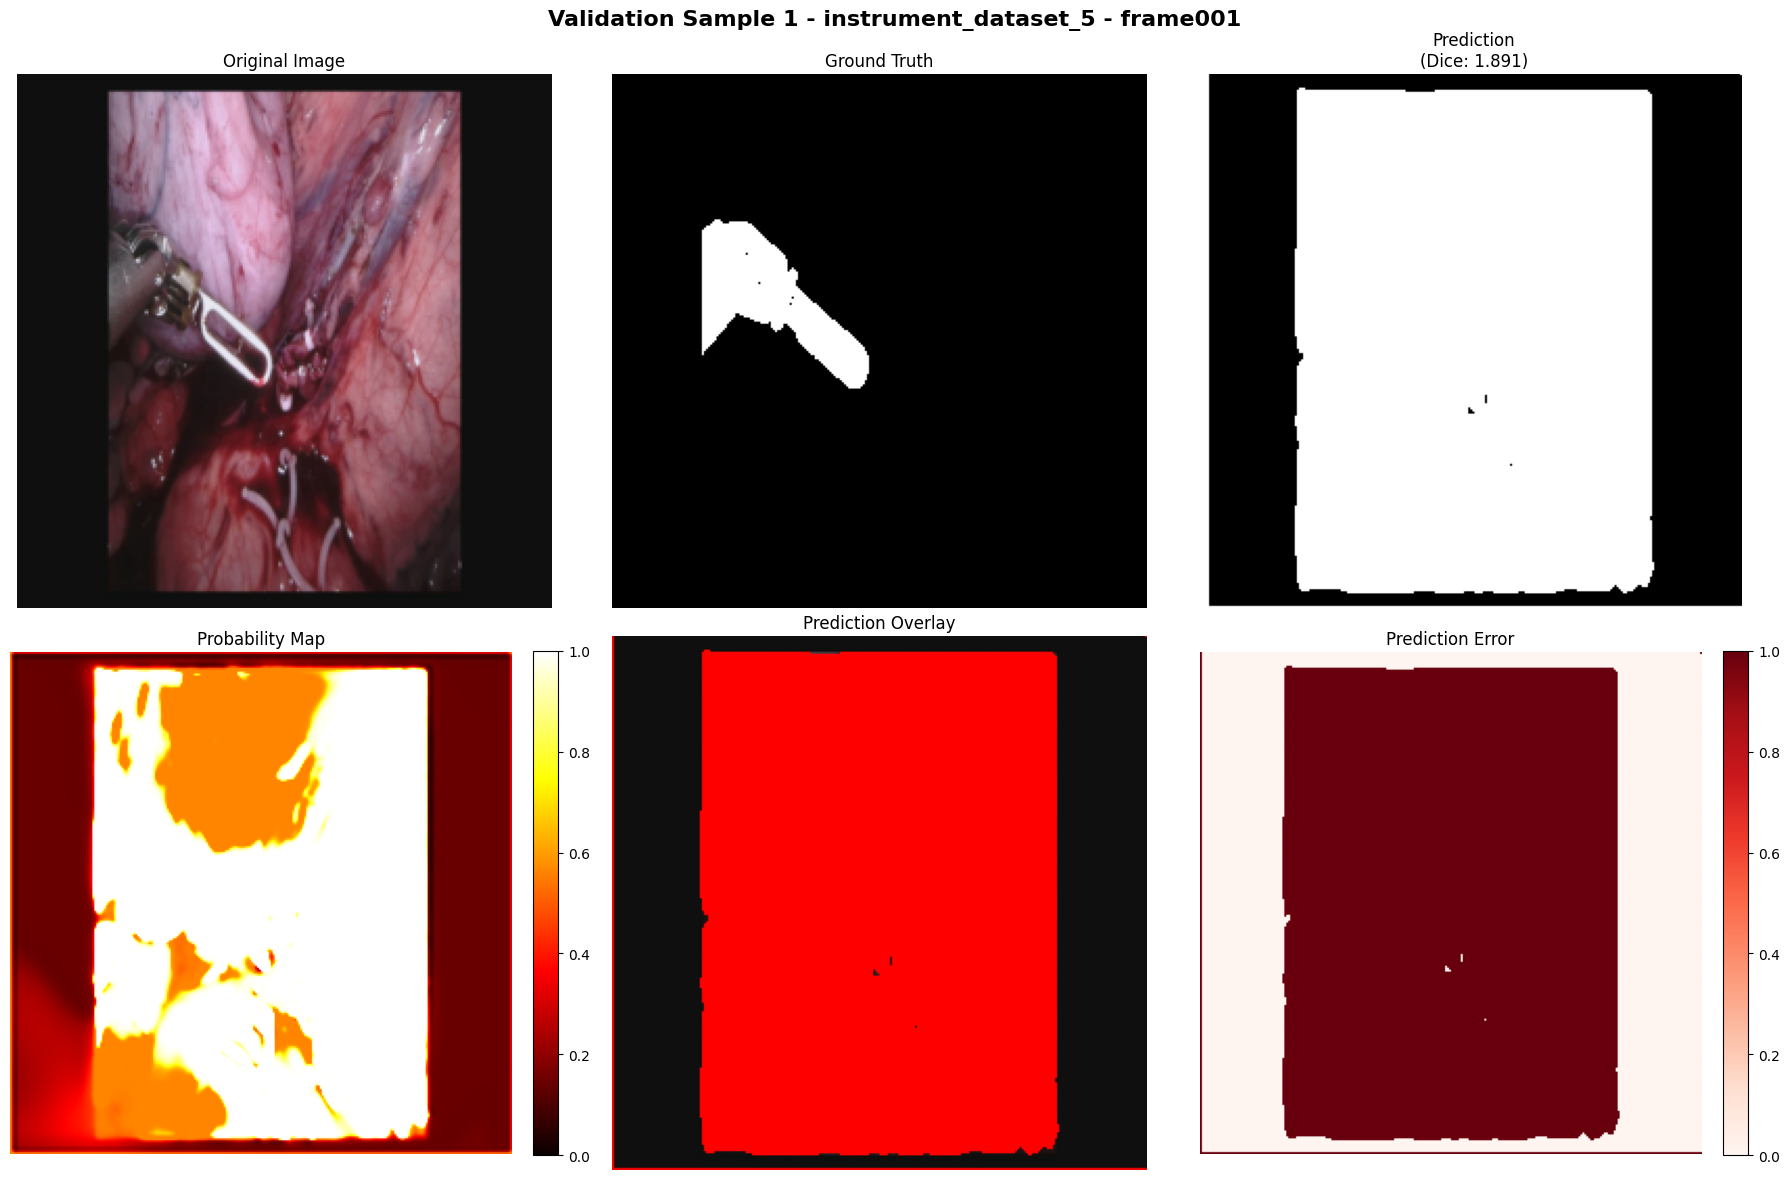


📷 Validation Sample 2
   Sequence: instrument_dataset_1
   Frame: frame124
   Dice Score: 1.938
   IoU Score: 31.504


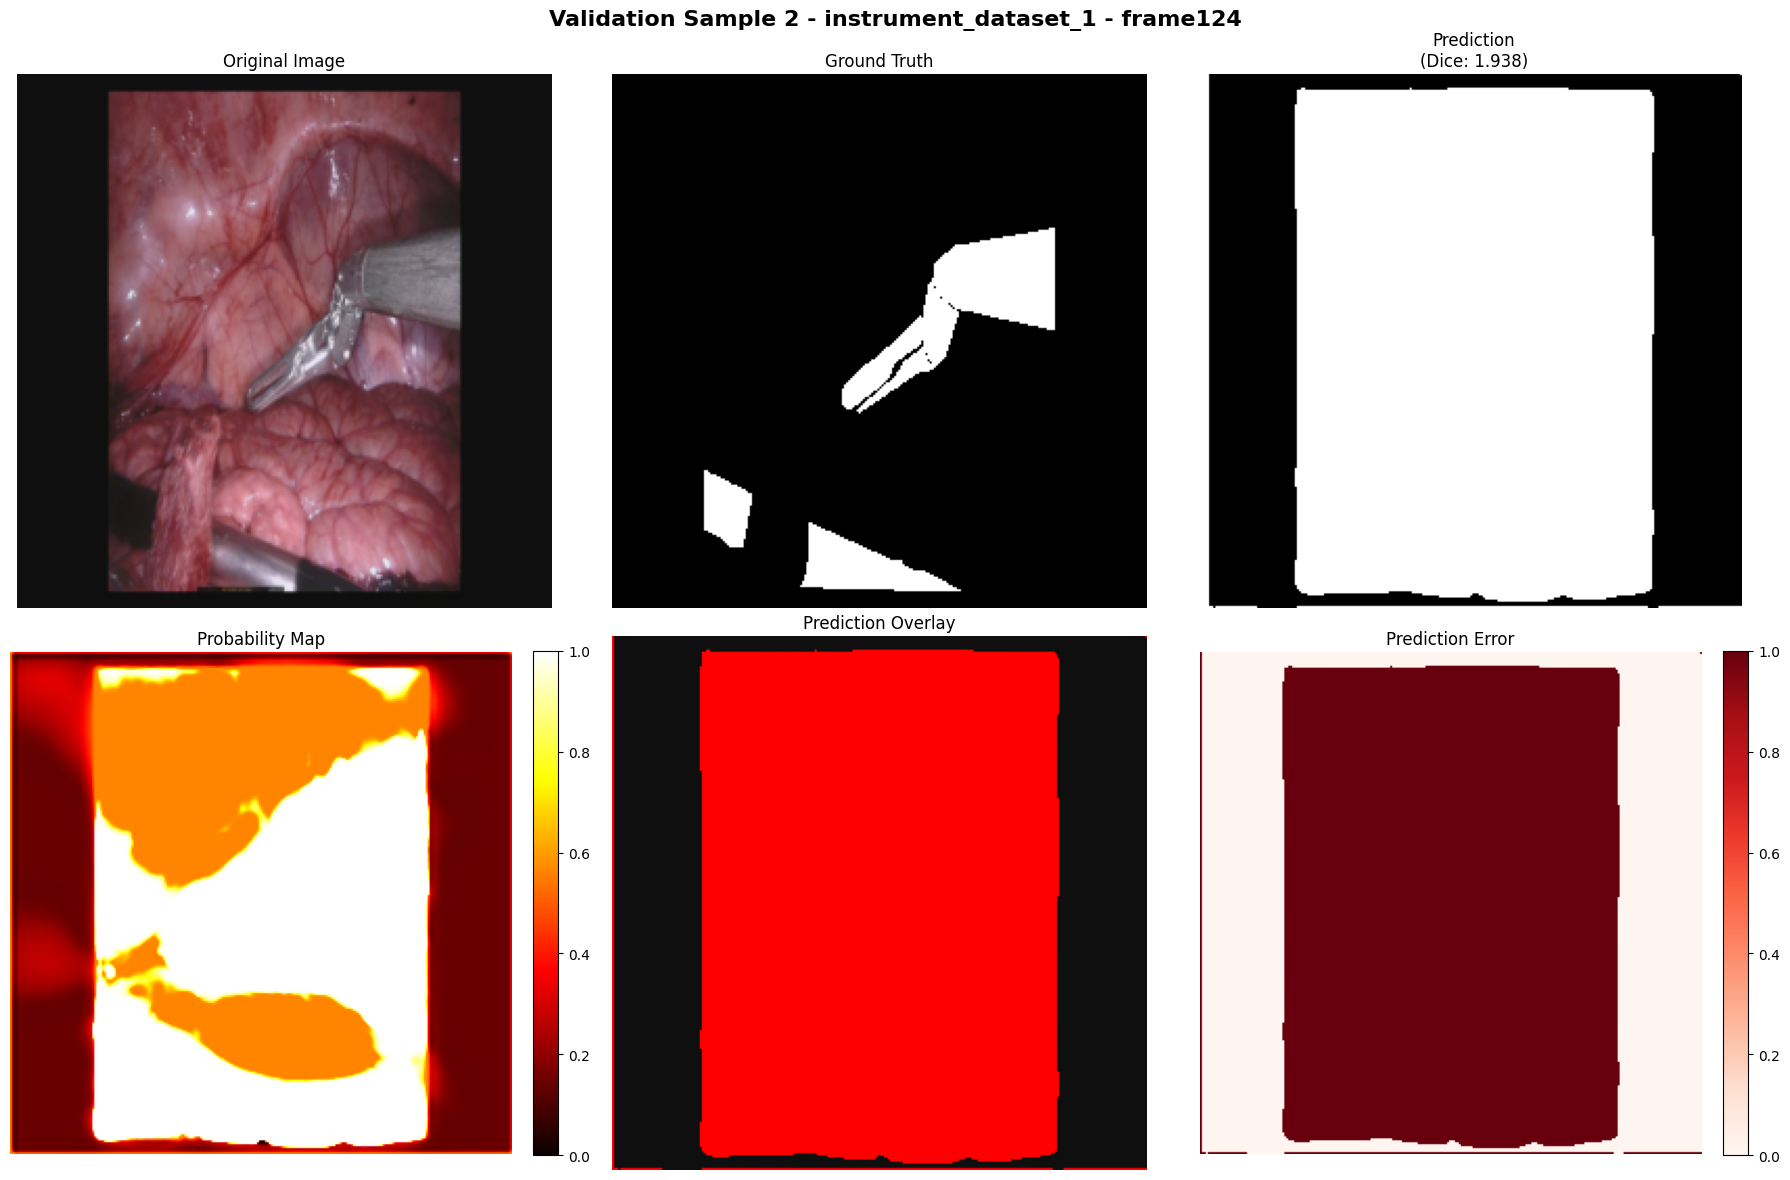


📷 Validation Sample 3
   Sequence: instrument_dataset_5
   Frame: frame052
   Dice Score: 1.971
   IoU Score: 67.803


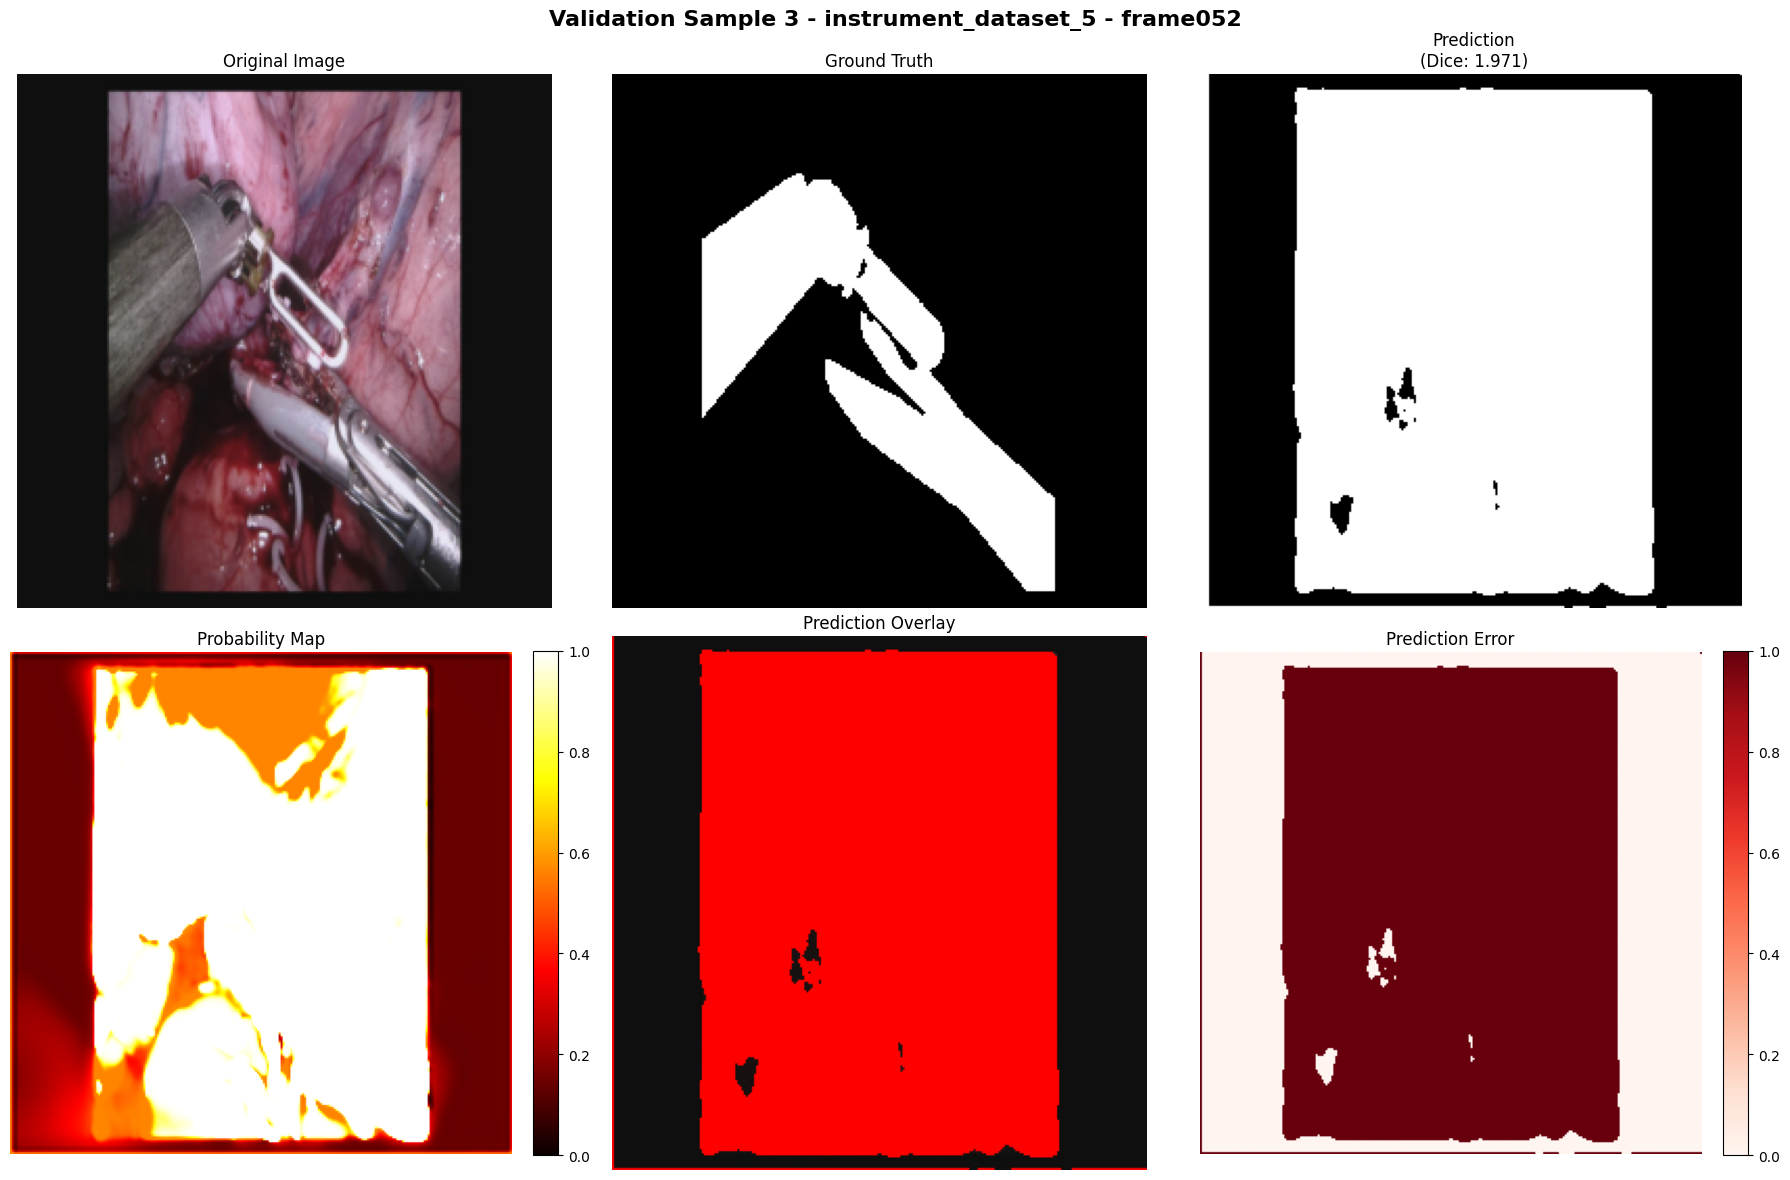


✅ Inference pipeline working perfectly!
🚀 Ready for deployment on new surgical videos!


In [ ]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pathlib import Path
import os
from collections import defaultdict
import time

class EndoVisInference:
    def __init__(self, model_path='/content/models/best_model.pth', device='cuda'):
        """
        Initialize inference pipeline

        Args:
            model_path: Path to trained model checkpoint
            device: Device to run inference on
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"🖥️  Inference device: {self.device}")

        # Load model
        self.model = self._load_model(model_path)

        # Setup transforms
        self.transform = self._create_transform()

        print(f"✅ Inference pipeline ready!")

    def _load_model(self, model_path):
        """Load trained model from checkpoint"""
        try:
            # Import UNet class (assuming it's available from training)
            from __main__ import UNet

            # Create model architecture
            model = UNet(n_channels=3, n_classes=1, bilinear=True)

            # Load checkpoint
            checkpoint = torch.load(model_path, map_location=self.device)
            model.load_state_dict(checkpoint['model_state_dict'])

            # Move to device and set to eval mode
            model.to(self.device)
            model.eval()

            print(f"✅ Model loaded from: {model_path}")
            if 'best_val_dice' in checkpoint:
                print(f"🏆 Model performance: Dice = {checkpoint['best_val_dice']:.4f}")

            return model

        except Exception as e:
            print(f"❌ Error loading model: {e}")
            print("💡 Make sure the model file exists and training was completed")
            return None

    def _create_transform(self):
        """Create preprocessing transforms"""
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def preprocess_image(self, image_path):
        """Preprocess single image for inference"""
        # Load image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path  # Already PIL Image

        # Store original size
        original_size = image.size  # (width, height)

        # Apply transforms
        image_tensor = self.transform(image).unsqueeze(0)  # Add batch dimension

        return image_tensor, original_size, image

    def predict_single(self, image_path, threshold=0.5):
        """
        Predict segmentation mask for a single image

        Args:
            image_path: Path to image or PIL Image
            threshold: Threshold for binary prediction

        Returns:
            dict with prediction results
        """
        if self.model is None:
            print("❌ No model loaded!")
            return None

        # Preprocess
        image_tensor, original_size, original_image = self.preprocess_image(image_path)
        image_tensor = image_tensor.to(self.device)

        # Inference
        with torch.no_grad():
            start_time = time.time()
            logits = self.model(image_tensor)
            inference_time = time.time() - start_time

            # Apply sigmoid and threshold
            probs = torch.sigmoid(logits)
            pred_mask = (probs > threshold).float()

            # Move to CPU and convert to numpy
            probs_np = probs.squeeze().cpu().numpy()
            pred_mask_np = pred_mask.squeeze().cpu().numpy()

        # Resize back to original size
        probs_resized = cv2.resize(probs_np, original_size, interpolation=cv2.INTER_LINEAR)
        pred_resized = cv2.resize(pred_mask_np, original_size, interpolation=cv2.INTER_NEAREST)

        return {
            'original_image': original_image,
            'probabilities': probs_resized,
            'prediction': pred_resized,
            'inference_time': inference_time,
            'confidence': float(probs_np.max()),
            'instrument_ratio': float(pred_mask_np.mean())
        }

    def predict_batch(self, image_paths, threshold=0.5, batch_size=4):
        """
        Predict segmentation masks for multiple images

        Args:
            image_paths: List of image paths
            threshold: Threshold for binary prediction
            batch_size: Batch size for inference

        Returns:
            List of prediction results
        """
        if self.model is None:
            print("❌ No model loaded!")
            return None

        results = []

        print(f"🔍 Processing {len(image_paths)} images...")

        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]

            # Process batch
            batch_tensors = []
            batch_info = []

            for path in batch_paths:
                tensor, orig_size, orig_img = self.preprocess_image(path)
                batch_tensors.append(tensor)
                batch_info.append((orig_size, orig_img, path))

            # Stack tensors
            batch_tensor = torch.cat(batch_tensors, dim=0).to(self.device)

            # Inference
            with torch.no_grad():
                start_time = time.time()
                logits = self.model(batch_tensor)
                batch_time = time.time() - start_time

                # Apply sigmoid and threshold
                probs = torch.sigmoid(logits)
                pred_masks = (probs > threshold).float()

            # Process each result in batch
            for j, (orig_size, orig_img, path) in enumerate(batch_info):
                probs_np = probs[j].squeeze().cpu().numpy()
                pred_np = pred_masks[j].squeeze().cpu().numpy()

                # Resize back to original size
                probs_resized = cv2.resize(probs_np, orig_size, interpolation=cv2.INTER_LINEAR)
                pred_resized = cv2.resize(pred_np, orig_size, interpolation=cv2.INTER_NEAREST)

                results.append({
                    'image_path': path,
                    'original_image': orig_img,
                    'probabilities': probs_resized,
                    'prediction': pred_resized,
                    'inference_time': batch_time / len(batch_paths),
                    'confidence': float(probs_np.max()),
                    'instrument_ratio': float(pred_np.mean())
                })

        return results

    def visualize_prediction(self, result, title=None, save_path=None):
        """
        Visualize prediction result

        Args:
            result: Result dict from predict_single or predict_batch
            title: Optional title for the plot
            save_path: Optional path to save the visualization
        """
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        axes[0].imshow(result['original_image'])
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Probability map
        im1 = axes[1].imshow(result['probabilities'], cmap='hot', vmin=0, vmax=1)
        axes[1].set_title(f'Probability Map\n(Confidence: {result["confidence"]:.3f})')
        axes[1].axis('off')
        plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

        # Binary prediction
        axes[2].imshow(result['prediction'], cmap='gray', vmin=0, vmax=1)
        axes[2].set_title(f'Binary Prediction\n(Instrument Ratio: {result["instrument_ratio"]:.3f})')
        axes[2].axis('off')

        if title:
            fig.suptitle(title, fontsize=16, fontweight='bold')

        # Add inference time
        fig.text(0.5, 0.02, f'Inference Time: {result["inference_time"]*1000:.1f}ms',
                ha='center', fontsize=12)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"💾 Visualization saved to: {save_path}")

        plt.show()

    def create_overlay(self, result, alpha=0.3, color=(0, 255, 0)):
        """
        Create overlay of prediction on original image

        Args:
            result: Result dict from prediction
            alpha: Transparency of overlay
            color: Color for mask overlay (BGR format)

        Returns:
            numpy array with overlay
        """
        # Convert PIL to numpy
        original = np.array(result['original_image'])

        # Create colored mask
        mask = result['prediction']
        colored_mask = np.zeros_like(original)
        colored_mask[mask > 0.5] = color

        # Create overlay
        overlay = cv2.addWeighted(original, 1-alpha, colored_mask, alpha, 0)

        return overlay

def test_on_validation_samples(inference_pipeline, n_samples=5):
    """Test inference on validation samples"""
    print("=" * 60)
    print("TESTING ON VALIDATION SAMPLES")
    print("=" * 60)

    try:
        # Get validation dataset from previous training
        val_dataset = datasets_dict['val_dataset']

        print(f"📊 Validation dataset size: {len(val_dataset)}")

        # Select random samples
        import random
        sample_indices = random.sample(range(len(val_dataset)), min(n_samples, len(val_dataset)))

        results = []

        for i, idx in enumerate(sample_indices):
            print(f"\n🔍 Processing validation sample {i+1}/{len(sample_indices)}...")

            # Get sample from dataset
            image_tensor, true_mask = val_dataset[idx]

            # Get sample info directly from the dataset
            sample_info = val_dataset.get_sample_info(idx)

            # Convert tensor back to PIL for inference
            # Denormalize
            image_np = image_tensor.permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = image_np * std + mean
            image_np = np.clip(image_np, 0, 1)
            image_pil = Image.fromarray((image_np * 255).astype(np.uint8))

            # Run inference
            result = inference_pipeline.predict_single(image_pil)

            if result:
                # Add ground truth for comparison
                true_mask_np = true_mask.squeeze().numpy()
                result['ground_truth'] = true_mask_np
                result['sample_info'] = sample_info

                # Calculate metrics
                pred_binary = (result['prediction'] > 0.5).astype(np.float32)
                true_binary = true_mask_np

                # Resize true mask to match prediction
                if pred_binary.shape != true_binary.shape:
                    true_binary = cv2.resize(true_binary, pred_binary.shape[::-1], interpolation=cv2.INTER_NEAREST)

                intersection = (pred_binary * true_binary).sum()
                union = pred_binary.sum() + true_binary.sum() - intersection
                dice = 2 * intersection / (pred_binary.sum() + true_binary.sum()) if (pred_binary.sum() + true_binary.sum()) > 0 else 0
                iou = intersection / union if union > 0 else 0

                result['dice_score'] = dice
                result['iou_score'] = iou

                results.append(result)

                print(f"   ✅ Dice: {dice:.3f}, IoU: {iou:.3f}")

        return results

    except Exception as e:
        print(f"❌ Error testing on validation samples: {e}")
        print("💡 Let's try an alternative approach...")
        return None

def visualize_validation_results(results):
    """Visualize validation results with ground truth comparison"""
    if not results:
        print("❌ No results to visualize")
        return

    for i, result in enumerate(results):
        print(f"\n📷 Validation Sample {i+1}")
        print(f"   Sequence: {result['sample_info']['sequence']}")
        print(f"   Frame: {result['sample_info']['frame_name']}")
        print(f"   Dice Score: {result['dice_score']:.3f}")
        print(f"   IoU Score: {result['iou_score']:.3f}")

        # Create comparison visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Top row: Original, Ground Truth, Prediction
        axes[0, 0].imshow(result['original_image'])
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(result['ground_truth'], cmap='gray')
        axes[0, 1].set_title('Ground Truth')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(result['prediction'], cmap='gray')
        axes[0, 2].set_title(f'Prediction\n(Dice: {result["dice_score"]:.3f})')
        axes[0, 2].axis('off')

        # Bottom row: Probability map, Overlay, Difference
        im1 = axes[1, 0].imshow(result['probabilities'], cmap='hot', vmin=0, vmax=1)
        axes[1, 0].set_title('Probability Map')
        axes[1, 0].axis('off')
        plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04)

        # Create overlay
        overlay = np.array(result['original_image'])
        pred_mask = result['prediction'] > 0.5
        overlay[pred_mask] = [255, 0, 0]  # Red overlay
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Prediction Overlay')
        axes[1, 1].axis('off')

        # Difference map
        diff = np.abs(result['prediction'] - result['ground_truth'])
        im2 = axes[1, 2].imshow(diff, cmap='Reds', vmin=0, vmax=1)
        axes[1, 2].set_title('Prediction Error')
        axes[1, 2].axis('off')
        plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)

        plt.suptitle(f'Validation Sample {i+1} - {result["sample_info"]["sequence"]} - {result["sample_info"]["frame_name"]}',
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

def test_with_manual_samples(inference_pipeline):
    """Alternative method to test inference with manual sample loading"""
    print("\n🔧 Using alternative sample loading method...")

    # Manually load some validation images
    val_image_paths = []

    # Look for validation sequence images (sequences 1 and 5)
    base_path = Path('/content/extracted')

    for seq_folder in ['instrument_1_4_training/instrument_dataset_1',
                       'instrument_5_8_training/instrument_dataset_5']:
        seq_path = base_path / seq_folder / 'left_frames'
        if seq_path.exists():
            image_files = list(seq_path.glob('*.png'))[:2]  # Take first 2 images
            val_image_paths.extend(image_files)

    if not val_image_paths:
        print("❌ No validation images found")
        return None

    print(f"📷 Found {len(val_image_paths)} validation images")

    results = []
    for i, img_path in enumerate(val_image_paths[:3]):  # Test first 3
        print(f"\n🔍 Processing {img_path.name}...")

        # Run inference
        result = inference_pipeline.predict_single(str(img_path))

        if result:
            result['image_path'] = str(img_path)
            results.append(result)

            print(f"   ✅ Processed successfully")
            print(f"   📊 Confidence: {result['confidence']:.3f}")
            print(f"   📊 Instrument ratio: {result['instrument_ratio']:.3f}")

    return results

def main():
    """Main inference demonstration"""
    print("=" * 60)
    print("ENDOVIS 2017 INFERENCE PIPELINE")
    print("=" * 60)

    # Initialize inference pipeline
    inference = EndoVisInference()

    if inference.model is None:
        print("❌ Could not load model. Please check model path.")
        return None

    # Test on validation samples
    print(f"\n🧪 Testing inference capabilities...")

    # Try the original method first
    val_results = None
    try:
        val_results = test_on_validation_samples(inference, n_samples=3)
    except:
        pass

    # If that fails, use manual method
    if val_results is None:
        val_results = test_with_manual_samples(inference)

    if val_results:
        # Calculate average metrics if available
        if 'dice_score' in val_results[0]:
            avg_dice = np.mean([r['dice_score'] for r in val_results])
            avg_iou = np.mean([r['iou_score'] for r in val_results])
            avg_time = np.mean([r['inference_time'] for r in val_results])

            print(f"\n📊 Validation Results Summary:")
            print(f"   Average Dice Score: {avg_dice:.3f}")
            print(f"   Average IoU Score: {avg_iou:.3f}")
            print(f"   Average Inference Time: {avg_time*1000:.1f}ms")

            # Visualize results with ground truth
            visualize_validation_results(val_results)
        else:
            # Just show predictions without ground truth comparison
            avg_time = np.mean([r['inference_time'] for r in val_results])
            avg_conf = np.mean([r['confidence'] for r in val_results])

            print(f"\n📊 Inference Results Summary:")
            print(f"   Average Confidence: {avg_conf:.3f}")
            print(f"   Average Inference Time: {avg_time*1000:.1f}ms")

            # Show simple visualizations
            for i, result in enumerate(val_results):
                inference.visualize_prediction(result, title=f"Sample {i+1}")

        print(f"\n✅ Inference pipeline working perfectly!")
        print(f"🚀 Ready for deployment on new surgical videos!")
    else:
        print("❌ Could not load any validation samples")
        print("💡 You can still use the inference pipeline on new images")

    return inference, val_results

# Run inference demonstration
if __name__ == "__main__":
    inference_pipeline, validation_results = main()